# 🗳️ Elecciones EEUU 2020

🧑‍💻 Lucía Cordero | Jorge Garcelán

![Election Results](https://www.porunmundomasjusto.es/wp-content/uploads/2020/11/mundomasjusto.png)


<div class="warning" style='padding:0.1em; border-left: 4px solid #17a2b8; background-color:#e8f8ff;'>
<span>
<p style='margin-top:1em; margin-left:1em; text-align:left'>
<b>🎯Motivación y Objetivos</b></p>
<p style='margin-left:1em;'>
Este proyecto de análisis de datos está basado en los resultados de las <strong>elecciones presidenciales de Estados Unidos de 2020</strong>. Inspirados por nuestro interés en la política y teniendo en cuenta que las elecciones presidenciales de EE.UU. de 2024 son el 5 de noviembre, se nos ocurrió abordar este tema.
<br><br>
    El objetivo es aplicar técnicas de <strong>aprendizaje supervisado</strong> y <strong>no supervisado</strong> para explorar patrones y tendencias, así como predecir los resultados electorales en función de las características socioeconómicas y demográficas de cada condado. Este enfoque nos permite estudiar cómo estos factores influyen en los comportamientos de los votantes y cómo podrían anticiparse los resultados de futuras elecciones.
</p>
</span>
</div>

<div style="border-left: 4px solid #ffa500; background-color: #fff4e5; padding: 10px;">
    <strong>⚠️Warning:</strong> Es importante mencionar que no hemos podido utilizar los datos de 2024 como test pues no se encuentran disponibles todavía.
</div>


## Librerías

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objs as go
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression


## Datasets

### Seleccionar año

In [16]:
CENSUS_YEAR = 2023

### Cargar características socioeconómicas y demográficas por condado

📊 Los datos socioeconómicos y demográficos son de elaboración propia y han sido extraídos usando la [`API del Censo de Estados Unidos`](https://www.census.gov/data/developers/data-sets.html) 

In [17]:
# Cargar datos
all_data = pd.read_csv(f"data/census_data_acs_{CENSUS_YEAR}.csv", header=0, sep=",")

# Renombrar columnas
all_data.rename(columns={"state": "state_code"}, inplace=True)
all_data.rename(columns={"county": "county_code"}, inplace=True)

# Filtrar los datos para excluir el estado 02 (Alaska)
all_data = all_data[all_data["state_code"] != 2]

# Filtrar los datos para excluir el estado 72 (Puerto Rico)
all_data = all_data[all_data["state_code"] != 72]

# Mostrar la tabla
all_data

,state_code,county_code,pop_total_2023,median_age_2023,median_income_2023,households_median_value_2023,households_avg_size_2023,households_total_2023,households_median_gross_rent_2023,mean_travel_time_2023,...,bachelors_rate_2023,poverty_rate_2023,households_renter_rate_2023,households_owner_rate_2023,households_limited_english_rate_2023,households_no_internet_rate_2023,unemployment_rate_2023,public_transport_rate_2023,no_health_insurance_rate_2023,county_fips
0,1,1,59285,39.2,69841,197900,2.61,22523,1200,25415,...,10.99,10.58,25.09,74.91,0.49,7.63,2.54,0.11,7.20,1001
1,1,3,239945,43.7,75019,287000,2.50,94642,1211,97455,...,14.73,10.34,22.46,77.54,0.84,8.20,3.19,0.04,8.06,1003
2,1,5,24757,40.7,44290,109900,2.39,9080,644,7989,...,4.76,19.17,32.51,67.49,2.47,20.45,5.71,0.07,9.49,1005
3,1,7,22152,41.3,51215,132600,2.74,7571,802,7999,...,5.06,19.22,22.82,77.18,0.70,16.96,9.98,0.04,7.81,1007
4,1,9,59292,40.9,61096,169700,2.67,21977,743,23976,...,6.89,13.95,20.49,79.51,1.81,13.81,5.84,0.00,10.11,1009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3139,56,37,41786,37.4,76464,242900,2.45,16863,913,19567,...,8.73,13.25,26.02,73.98,2.00,7.27,5.79,1.14,12.85,56037
3140,56,39,23358,40.1,112681,1371900,2.39,9383,1758,12293,...,31.24,6.99,38.47,61.53,4.23,3.51,2.45,1.31,10.00,56039
3141,56,41,20605,36.7,82672,255400,2.73,7479,882,8936,...,10.02,7.44,23.47,76.53,0.64,6.65,3.51,0.44,10.85,56041
3142,56,43,7708,44.2,62648,188600,2.21,3417,725,3482,...,10.57,8.45,25.81,74.19,0.29,12.23,2.03,0.01,12.22,56043


### Cargar los resultados electorales de 2020 por condado

📊 Los datos electorales han sido extraídos de la siguiente fuente:
[`US_County_Level_Election_Results_08-20.csv`](https://github.com/tonmcg/US_County_Level_Election_Results_08-20) 

In [18]:
ELECTORAL_YEAR = CENSUS_YEAR + 1

In [19]:
# Cargar datos
d1 = pd.read_csv(f"data/{ELECTORAL_YEAR}_US_County_Level_Presidential_Results.csv")

# Crear nueva columna 'votes_others'
d1['votes_others'] = d1['total_votes'] - (d1['votes_gop'] + d1['votes_dem'])

# Crear nueva columna 'perc votes_others'
d1['perc votes_others'] = 1 - d1['per_dem'] - d1['per_gop']

# Quedarse con columnas específicas
d1 = d1[['state_name', 'county_fips', 'county_name', 'votes_gop', 'votes_dem', 'total_votes', 'votes_others', 'perc votes_others', 'per_dem', 'per_gop']]

# Renombrar columnas
# d1.columns = ["state", "fips", "county", f"Trump_{ELECTORAL_YEAR}", f"Biden_{ELECTORAL_YEAR}", f"Total_{ELECTORAL_YEAR}", f"Other_{ELECTORAL_YEAR}", f"Perc_Other_{ELECTORAL_YEAR}", f"Perc_Biden_{ELECTORAL_YEAR}", f"Perc_Trump_{ELECTORAL_YEAR}"]
d1.rename(columns={"state_name": "state"}, inplace=True)
d1.rename(columns={"county_name": "county"}, inplace=True)
d1.rename(columns={"votes_gop": f"votes_gop_{ELECTORAL_YEAR}"}, inplace=True)
d1.rename(columns={"votes_dem": f"votes_dem_{ELECTORAL_YEAR}"}, inplace=True)
d1.rename(columns={"total_votes": f"total_votes_{ELECTORAL_YEAR}"}, inplace=True)
d1.rename(columns={"votes_others": f"votes_others_{ELECTORAL_YEAR}"}, inplace=True)
d1.rename(columns={"perc votes_others": f"per_votes_others_{ELECTORAL_YEAR}"}, inplace=True)
d1.rename(columns={"per_dem": f"per_dem_{ELECTORAL_YEAR}"}, inplace=True)
d1.rename(columns={"per_gop": f"per_gop_{ELECTORAL_YEAR}"}, inplace=True)

# Mostrar la tabla
d1

,state,county_fips,county,votes_gop_2024,votes_dem_2024,total_votes_2024,votes_others_2024,per_votes_others_2024,per_dem_2024,per_gop_2024
0,Alabama,1001,Autauga County,20484,7439,28190,267,0.009471,0.263888,0.726641
1,Alabama,1003,Baldwin County,95798,24934,121808,1076,0.008834,0.204699,0.786467
2,Alabama,1005,Barbour County,5606,4158,9832,68,0.006916,0.422905,0.570179
3,Alabama,1007,Bibb County,7572,1619,9241,50,0.005411,0.175197,0.819392
4,Alabama,1009,Blount County,25354,2576,28115,185,0.006580,0.091624,0.901796
...,...,...,...,...,...,...,...,...,...,...
3155,Wyoming,56037,Sweetwater County,12541,3731,16569,297,0.017925,0.225180,0.756895
3156,Wyoming,56039,Teton County,4134,8748,13077,195,0.014912,0.668961,0.316128
3157,Wyoming,56041,Uinta County,7282,1561,8984,141,0.015695,0.173753,0.810552
3158,Wyoming,56043,Washakie County,3125,656,3841,60,0.015621,0.170789,0.813590


### Unir los dos datasets

In [20]:
# Unir los dos datasets
data = pd.merge(d1, all_data, how='right', on=["county_fips"])

# Código FIPS tiene que tener 5 dígitos
data['county_fips'] = data['county_fips'].astype(str).str.zfill(5)

# Mostrar la tabla
data

,state,county_fips,county,votes_gop_2024,votes_dem_2024,total_votes_2024,votes_others_2024,per_votes_others_2024,per_dem_2024,per_gop_2024,...,high_school_rate_2023,bachelors_rate_2023,poverty_rate_2023,households_renter_rate_2023,households_owner_rate_2023,households_limited_english_rate_2023,households_no_internet_rate_2023,unemployment_rate_2023,public_transport_rate_2023,no_health_insurance_rate_2023
0,Alabama,01001,Autauga County,20484.0,7439.0,28190.0,267.0,0.009471,0.263888,0.726641,...,18.70,10.99,10.58,25.09,74.91,0.49,7.63,2.54,0.11,7.20
1,Alabama,01003,Baldwin County,95798.0,24934.0,121808.0,1076.0,0.008834,0.204699,0.786467,...,16.15,14.73,10.34,22.46,77.54,0.84,8.20,3.19,0.04,8.06
2,Alabama,01005,Barbour County,5606.0,4158.0,9832.0,68.0,0.006916,0.422905,0.570179,...,21.48,4.76,19.17,32.51,67.49,2.47,20.45,5.71,0.07,9.49
3,Alabama,01007,Bibb County,7572.0,1619.0,9241.0,50.0,0.005411,0.175197,0.819392,...,24.60,5.06,19.22,22.82,77.18,0.70,16.96,9.98,0.04,7.81
4,Alabama,01009,Blount County,25354.0,2576.0,28115.0,185.0,0.006580,0.091624,0.901796,...,19.58,6.89,13.95,20.49,79.51,1.81,13.81,5.84,0.00,10.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3109,Wyoming,56037,Sweetwater County,12541.0,3731.0,16569.0,297.0,0.017925,0.225180,0.756895,...,15.46,8.73,13.25,26.02,73.98,2.00,7.27,5.79,1.14,12.85
3110,Wyoming,56039,Teton County,4134.0,8748.0,13077.0,195.0,0.014912,0.668961,0.316128,...,11.62,31.24,6.99,38.47,61.53,4.23,3.51,2.45,1.31,10.00
3111,Wyoming,56041,Uinta County,7282.0,1561.0,8984.0,141.0,0.015695,0.173753,0.810552,...,18.53,10.02,7.44,23.47,76.53,0.64,6.65,3.51,0.44,10.85
3112,Wyoming,56043,Washakie County,3125.0,656.0,3841.0,60.0,0.015621,0.170789,0.813590,...,19.30,10.57,8.45,25.81,74.19,0.29,12.23,2.03,0.01,12.22


## Preprocesamiento de datos

### Convertir variables categóricas en vectores

In [21]:
# Guardamos las variables en vectores para uso futuro
state_names = data['state']
fips_codes = data['county_fips']
county_names = data['county']

# Crear df para guardarlos
df_vectors = pd.DataFrame({
    'state': state_names,
    'fips': fips_codes,
    'county': county_names
})

# Guardar en archivo CSV
df_vectors.to_csv('data/state_fips_county.csv', index=False)

### Calcular el ganador en cada condado

<div style="border-left: 4px solid #0074cc; background-color: #e6f4ff; padding: 10px;">
    <strong>Nota:</strong> Por simplicidad, para calcular el ganador en cada condado asumimos que si hay un empate el ganador es Biden. En cualquier otro caso, el ganador será el que haya obtenido más del 50% de los votos.
</div>


In [22]:
data[f'winner_{ELECTORAL_YEAR}'] = data[f'per_dem_{ELECTORAL_YEAR}'].apply(lambda x: "dem" if x >= 0.50 else "gop")

### Valores ausentes (NAs)

In [23]:
data[data.isna().any(axis=1)] # todos son de Alaska

,state,county_fips,county,votes_gop_2024,votes_dem_2024,total_votes_2024,votes_others_2024,per_votes_others_2024,per_dem_2024,per_gop_2024,...,bachelors_rate_2023,poverty_rate_2023,households_renter_rate_2023,households_owner_rate_2023,households_limited_english_rate_2023,households_no_internet_rate_2023,unemployment_rate_2023,public_transport_rate_2023,no_health_insurance_rate_2023,winner_2024
520,NaN,15005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.28,30.23,100.0,0.0,0.0,0.0,0.0,23.26,2.33,gop


In [24]:
data = data.dropna(how="any")
data[data.isna().any(axis=1)]

,state,county_fips,county,votes_gop_2024,votes_dem_2024,total_votes_2024,votes_others_2024,per_votes_others_2024,per_dem_2024,per_gop_2024,...,bachelors_rate_2023,poverty_rate_2023,households_renter_rate_2023,households_owner_rate_2023,households_limited_english_rate_2023,households_no_internet_rate_2023,unemployment_rate_2023,public_transport_rate_2023,no_health_insurance_rate_2023,winner_2024


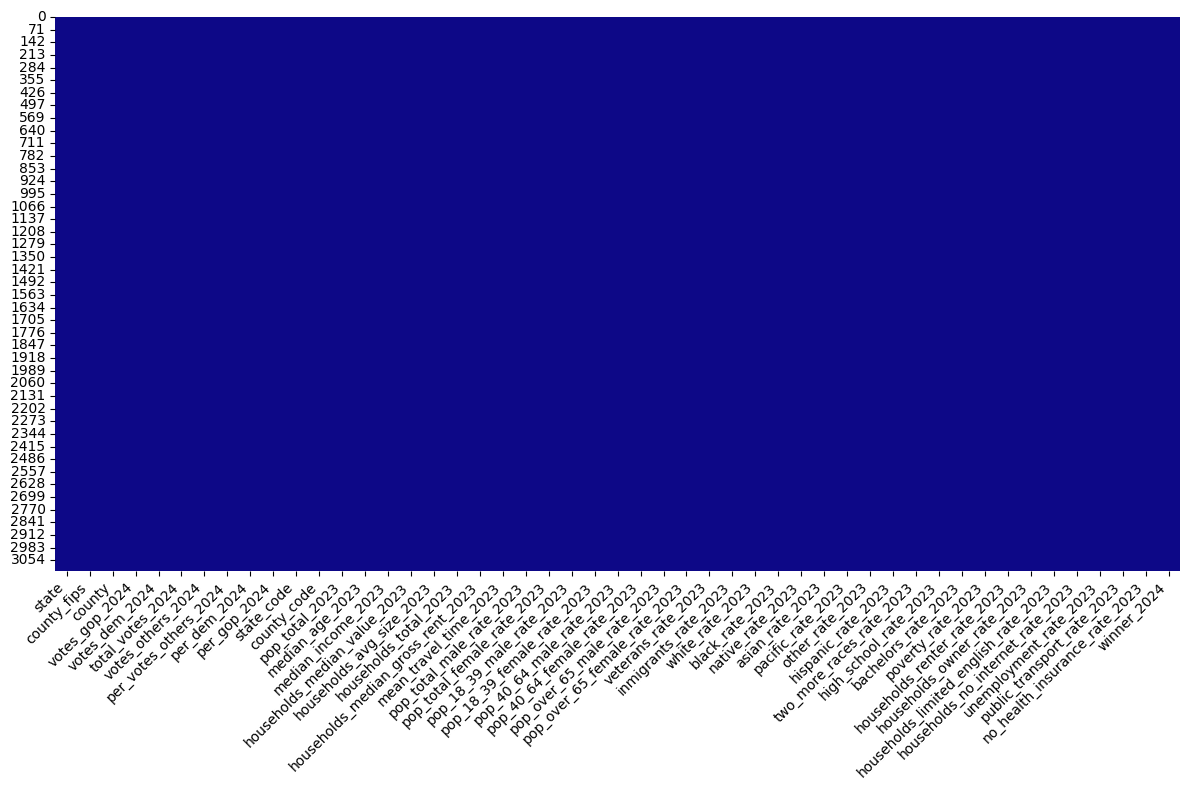

In [25]:
# Aumentar el tamaño del gráfico y rotar las etiquetas del eje X
plt.figure(figsize=(12, 8))  # Aumentar el tamaño del gráfico
sns.heatmap(data.isnull(), cbar=False, cmap="plasma")

# Rotar las etiquetas del eje X
plt.xticks(rotation=45, ha='right')

# Ajustar el layout para evitar que se corten las etiquetas
plt.tight_layout()

# Guardar el gráfico como PNG con fondo transparente
plt.savefig(f"imgs/missing_values_{ELECTORAL_YEAR}.png", format="png", transparent=True)

# Mostrar el gráfico
plt.show()

### Eliminar columnas

Tras un análisis exploratorio de todas las variables del dataset hemos decidido eliminar:
- **Variables categóricas**: *'state', 'fips', 'county'*.
- **Variables complementarias a la variable objetivo**: *'Trump_2020', 'Perc_Trump_2020'*.
- **Variables no usadas en el estudio**: *'age_over_85_2019', 'age_under_5_2019', 'households_2019', 'households_speak_asian_or_pac_isl_2019', 'households_speak_other_2019', 'households_speak_other_indo_euro_lang_2019', 'households_speak_spanish_2019', 'household_has_broadband_2019', 'household_has_smartphone_2019', 'household_has_computer_2019', 'housing_mobile_homes_2019', 'housing_one_unit_structures_2019', 'housing_two_unit_structures_2019', 'mean_household_income_2019', 'mean_work_travel_2019', 'median_household_income_2019', 'median_individual_income_2019', 'median_individual_income_age_25plus_2019', 'persons_per_household_2019', 'poverty_65_and_over_2019', 'poverty_under_18_2019', 'uninsured_65_and_older_2019', 'uninsured_under_19_2019', 'uninsured_under_6_2019'*.

In [26]:
columns_to_drop = ['county_fips', "state", "county", "state_code", "county_code"]  # Nombres de las columnas a eliminar
data = data.drop(columns=columns_to_drop)

### Tabla Final

In [27]:
data.to_csv(f"data/final_data_{ELECTORAL_YEAR}.csv")
data

,votes_gop_2024,votes_dem_2024,total_votes_2024,votes_others_2024,per_votes_others_2024,per_dem_2024,per_gop_2024,pop_total_2023,median_age_2023,median_income_2023,...,bachelors_rate_2023,poverty_rate_2023,households_renter_rate_2023,households_owner_rate_2023,households_limited_english_rate_2023,households_no_internet_rate_2023,unemployment_rate_2023,public_transport_rate_2023,no_health_insurance_rate_2023,winner_2024
0,20484.0,7439.0,28190.0,267.0,0.009471,0.263888,0.726641,59285,39.2,69841,...,10.99,10.58,25.09,74.91,0.49,7.63,2.54,0.11,7.20,gop
1,95798.0,24934.0,121808.0,1076.0,0.008834,0.204699,0.786467,239945,43.7,75019,...,14.73,10.34,22.46,77.54,0.84,8.20,3.19,0.04,8.06,gop
2,5606.0,4158.0,9832.0,68.0,0.006916,0.422905,0.570179,24757,40.7,44290,...,4.76,19.17,32.51,67.49,2.47,20.45,5.71,0.07,9.49,gop
3,7572.0,1619.0,9241.0,50.0,0.005411,0.175197,0.819392,22152,41.3,51215,...,5.06,19.22,22.82,77.18,0.70,16.96,9.98,0.04,7.81,gop
4,25354.0,2576.0,28115.0,185.0,0.006580,0.091624,0.901796,59292,40.9,61096,...,6.89,13.95,20.49,79.51,1.81,13.81,5.84,0.00,10.11,gop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3109,12541.0,3731.0,16569.0,297.0,0.017925,0.225180,0.756895,41786,37.4,76464,...,8.73,13.25,26.02,73.98,2.00,7.27,5.79,1.14,12.85,gop
3110,4134.0,8748.0,13077.0,195.0,0.014912,0.668961,0.316128,23358,40.1,112681,...,31.24,6.99,38.47,61.53,4.23,3.51,2.45,1.31,10.00,dem
3111,7282.0,1561.0,8984.0,141.0,0.015695,0.173753,0.810552,20605,36.7,82672,...,10.02,7.44,23.47,76.53,0.64,6.65,3.51,0.44,10.85,gop
3112,3125.0,656.0,3841.0,60.0,0.015621,0.170789,0.813590,7708,44.2,62648,...,10.57,8.45,25.81,74.19,0.29,12.23,2.03,0.01,12.22,gop


### Análisis Exploratorio de Datos

#### Correlación

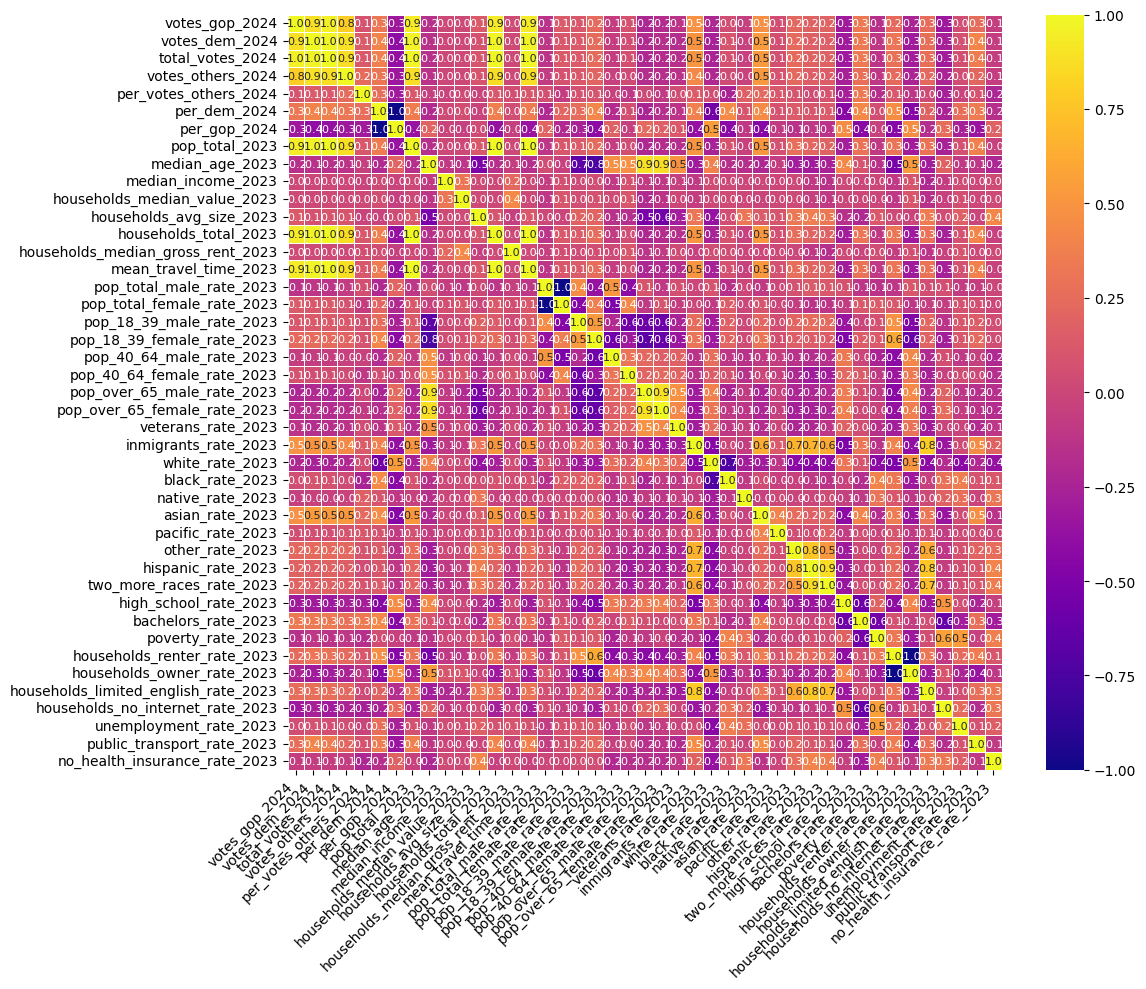

In [28]:
# Calcular la matriz de correlación sin la variable "Winner_2020"
corr_matrix = data.iloc[:, :-1].corr()

# Crear un mapa de calor de la matriz de correlación con etiquetas ajustadas
plt.figure(figsize=(12, 10))  # Aumentar el tamaño del gráfico
sns.heatmap(corr_matrix, annot=True, cmap="plasma", fmt=".1f", linewidths=0.5, annot_kws={"size": 8})

# Rotar las etiquetas del eje X y ajustar el layout
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)  # Mantener las etiquetas del eje Y rectas

# Ajustar el layout para que no se corten las etiquetas
plt.tight_layout()

# Guardar el gráfico como PNG con fondo transparente
plt.savefig(f"imgs/corr_plot_{ELECTORAL_YEAR}.png", format="png", transparent=True)

# Mostrar el gráfico
plt.show()

#### Ganador por condado

In [29]:
plot_data = data.copy()
plot_data['state'] = state_names
plot_data

,votes_gop_2024,votes_dem_2024,total_votes_2024,votes_others_2024,per_votes_others_2024,per_dem_2024,per_gop_2024,pop_total_2023,median_age_2023,median_income_2023,...,poverty_rate_2023,households_renter_rate_2023,households_owner_rate_2023,households_limited_english_rate_2023,households_no_internet_rate_2023,unemployment_rate_2023,public_transport_rate_2023,no_health_insurance_rate_2023,winner_2024,state
0,20484.0,7439.0,28190.0,267.0,0.009471,0.263888,0.726641,59285,39.2,69841,...,10.58,25.09,74.91,0.49,7.63,2.54,0.11,7.20,gop,Alabama
1,95798.0,24934.0,121808.0,1076.0,0.008834,0.204699,0.786467,239945,43.7,75019,...,10.34,22.46,77.54,0.84,8.20,3.19,0.04,8.06,gop,Alabama
2,5606.0,4158.0,9832.0,68.0,0.006916,0.422905,0.570179,24757,40.7,44290,...,19.17,32.51,67.49,2.47,20.45,5.71,0.07,9.49,gop,Alabama
3,7572.0,1619.0,9241.0,50.0,0.005411,0.175197,0.819392,22152,41.3,51215,...,19.22,22.82,77.18,0.70,16.96,9.98,0.04,7.81,gop,Alabama
4,25354.0,2576.0,28115.0,185.0,0.006580,0.091624,0.901796,59292,40.9,61096,...,13.95,20.49,79.51,1.81,13.81,5.84,0.00,10.11,gop,Alabama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3109,12541.0,3731.0,16569.0,297.0,0.017925,0.225180,0.756895,41786,37.4,76464,...,13.25,26.02,73.98,2.00,7.27,5.79,1.14,12.85,gop,Wyoming
3110,4134.0,8748.0,13077.0,195.0,0.014912,0.668961,0.316128,23358,40.1,112681,...,6.99,38.47,61.53,4.23,3.51,2.45,1.31,10.00,dem,Wyoming
3111,7282.0,1561.0,8984.0,141.0,0.015695,0.173753,0.810552,20605,36.7,82672,...,7.44,23.47,76.53,0.64,6.65,3.51,0.44,10.85,gop,Wyoming
3112,3125.0,656.0,3841.0,60.0,0.015621,0.170789,0.813590,7708,44.2,62648,...,8.45,25.81,74.19,0.29,12.23,2.03,0.01,12.22,gop,Wyoming


In [30]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color=f'winner_{ELECTORAL_YEAR}',
                    hover_name=county_names,
                    scope='usa',  # Mostrar todo Estados Unidos
                    color_discrete_map={
                        "dem": "#3951a2",
                        "gop": "#af2b39"
                    }
                   )

# Ajustar el tamaño y márgenes del gráfico
fig.update_layout(
    title_text="Ganador por condado",
    title_x=0.5,  # Centrar el título
    width=900,   # Aumentar el ancho del gráfico
    height=600,  # Aumentar la altura del gráfico
    margin={"r":0,"t":50,"l":0,"b":0},  # Ajustar márgenes para que no se corte
    paper_bgcolor='rgba(0,0,0,0)',  # Fondo transparente
    plot_bgcolor='rgba(0,0,0,0)'   # Fondo transparente
)

# Ajustar la visualización geográfica
fig.update_geos(
    fitbounds="locations",  # Ajustar el mapa según las ubicaciones FIPS
    visible=False  # Ocultar detalles de la costa y otras líneas exteriores
)

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)


# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.3, marker_line_color="black")

# Mostrar el gráfico
fig.show()


ValueError: All arguments should have the same length. The length of column argument `df[color]` is 3113, whereas the length of previously-processed arguments ['hover_name', 'locations'] is 3114

#### Población

##### Población total

In [ ]:
plot_data[f'log_pop_total_{CENSUS_YEAR}'] = np.log(plot_data[f'pop_total_{CENSUS_YEAR}'])

# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=plot_data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color=f'log_pop_total_{CENSUS_YEAR}',
                    hover_name=county_names,
                    scope='usa'
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Distribución del número de habitantes (log) por cada condado",
                  title_x=0.5,  # Centrar el título
                  )

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa según las ubicaciones FIPS
# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


In [ ]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue=f"winner_{ELECTORAL_YEAR}", col_wrap=6, height=2, aspect=1.5, palette={"gop": "#e41a1c", "dem": "#377eb8"})
g.map(sns.scatterplot, f'log_pop_total_{CENSUS_YEAR}', f'per_dem_{ELECTORAL_YEAR}', alpha=0.8)

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='red', lw=0.8)


g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels(f'log_pop_total_{CENSUS_YEAR}', f'per_dem_{ELECTORAL_YEAR}')

plt.show()

##### Edad Mediana de la Población

In [ ]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=plot_data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color=f'median_age_{CENSUS_YEAR}',
                    hover_name=county_names,
                    scope='usa'
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Distribución de la edad (mediana) por cada condado",
                  title_x=0.5,  # Centrar el título
                  )

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


In [ ]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue=f"winner_{ELECTORAL_YEAR}", col_wrap=6, height=2, aspect=1.5, palette={"gop": "#e41a1c", "dem": "#377eb8"})

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='lightgray', lw=0.8)  # Línea horizontal en 50%
    ax.axvline(50, ls='--', color='lightgray', lw=0.8)  # Línea vertical en 50
    ax.set_xlim(0, 100)  # Ajustar el eje X hasta 100


# Scatterplot
g.map(sns.scatterplot, f'median_age_{CENSUS_YEAR}', f'per_dem_{ELECTORAL_YEAR}', alpha=0.8)


g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels(f'median_age_{CENSUS_YEAR}', f'per_dem_{ELECTORAL_YEAR}')

plt.show()

##### Porcentaje de hombres por condado

In [ ]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=plot_data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color=f'pop_total_male_rate_{CENSUS_YEAR}',
                    hover_name=county_names,
                    scope='usa'
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Distribución del porcentaje de hombres por cada condado",
                  title_x=0.5,  # Centrar el título
                  )

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


In [ ]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue=f"winner_{ELECTORAL_YEAR}", col_wrap=6, height=2, aspect=1.5, palette={"gop": "#e41a1c", "dem": "#377eb8"})

    # Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='lightgray', lw=0.8)  # Línea horizontal en 50%
    ax.axvline(50, ls='--', color='lightgray', lw=0.8)  # Línea vertical en 50
    ax.set_xlim(0, 100)  # Ajustar el eje X hasta 100


# Scatterplot
g.map(sns.scatterplot, f'pop_total_male_rate_{CENSUS_YEAR}', f'per_dem_{ELECTORAL_YEAR}', alpha=0.8)

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels(f'pop_total_male_rate_{CENSUS_YEAR}', f'per_dem_{ELECTORAL_YEAR}')

plt.show()

##### Porcentaje de mujeres por condado

In [ ]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=plot_data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color=f'pop_total_female_rate_{CENSUS_YEAR}',
                    hover_name=county_names,
                    scope='usa'
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Distribución del porcentaje de hombres por cada condado",
                  title_x=0.5,  # Centrar el título
                  )

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


In [ ]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue=f"winner_{ELECTORAL_YEAR}", col_wrap=6, height=2, aspect=1.5, palette={"gop": "#e41a1c", "dem": "#377eb8"})

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='lightgray', lw=0.8)  # Línea horizontal en 50%
    ax.axvline(50, ls='--', color='lightgray', lw=0.8)  # Línea vertical en 50
    ax.set_xlim(0, 100)  # Ajustar el eje X hasta 100


# Scatterplot
g.map(sns.scatterplot, f'pop_total_female_rate_{CENSUS_YEAR}', f'per_dem_{ELECTORAL_YEAR}', alpha=0.8)



g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels(f'pop_total_female_rate_{CENSUS_YEAR}', f'per_dem_{ELECTORAL_YEAR}')

plt.show()

#### Educación

##### Porcentaje de población con título de secundaria (High School) por condado

In [ ]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color=f'high_school_rate_{CENSUS_YEAR}',
                    hover_name=county_names,
                    scope='usa'
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Dsitribución de la población con título de secundaria por condado",
                  title_x=0.5,  # Centrar el título
                  )

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


In [ ]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue=f"winner_{ELECTORAL_YEAR}", col_wrap=10, height=2, aspect=1.5, palette={"gop": "#e41a1c", "dem": "#377eb8"})
g.map(sns.scatterplot, f'high_school_rate_{CENSUS_YEAR}', f'per_dem_{ELECTORAL_YEAR}', alpha=0.8)

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='red', lw=0.8)
    ax.axvline(50, ls='--', color='red', lw=0.8)
    ax.set_xlim(0, 100)

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels(f'high_school_rate_{CENSUS_YEAR}', f'per_dem_{ELECTORAL_YEAR}')

plt.show()

##### Porcentaje de población con título universitario (Bachelors) por condado

In [ ]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color=f'bachelors_rate_{CENSUS_YEAR}',
                    hover_name=county_names,
                    scope='usa'
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Dsitribución de la población con título universitario por condado",
                  title_x=0.5,  # Centrar el título
                  )

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


In [ ]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue=f"winner_{ELECTORAL_YEAR}", col_wrap=10, height=2, aspect=1.5, palette={"gop": "#e41a1c", "dem": "#377eb8"})
g.map(sns.scatterplot, f'bachelors_rate_{CENSUS_YEAR}', f'per_dem_{ELECTORAL_YEAR}', alpha=0.8)

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='red', lw=0.8)
    ax.axvline(50, ls='--', color='red', lw=0.8)
    ax.set_xlim(0, 100)

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels(f'bachelors_rate_{CENSUS_YEAR}', f'per_dem_{ELECTORAL_YEAR}')

plt.show()

#### Raza y Etnia

##### Porcentaje de población blanca (White) por condado

In [ ]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color=f'white_rate_{CENSUS_YEAR}',
                    hover_name=county_names,
                    scope='usa'
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Distribución de la población blanca por condado",
                  title_x=0.5,  # Centrar el título
                  )

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


In [ ]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue=f"winner_{ELECTORAL_YEAR}", col_wrap=10, height=2, aspect=1.5, palette={"gop": "#e41a1c", "dem": "#377eb8"})
g.map(sns.scatterplot, f"white_rate_{CENSUS_YEAR}", f'per_dem_{ELECTORAL_YEAR}', alpha=0.8)

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='red', lw=0.8)
    ax.axvline(50, ls='--', color='gray', lw=0.8)
    ax.set_xlim(0, 100)

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels(f"white_rate_{CENSUS_YEAR}", f'per_dem_{ELECTORAL_YEAR}')

plt.show()

##### Porcentaje de población negra (Black) por condado

In [ ]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color=f'black_rate_{CENSUS_YEAR}',
                    hover_name=county_names,
                    scope='usa'
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Distribución de la población negra por condado",
                  title_x=0.5,  # Centrar el título
                  )

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


In [ ]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue=f"winner_{ELECTORAL_YEAR}", col_wrap=10, height=2, aspect=1.5, palette={"gop": "#af2b39", "dem": "#145bb2"})
g.map(sns.scatterplot, f'black_rate_{CENSUS_YEAR}', f'per_dem_{ELECTORAL_YEAR}', alpha=0.8)

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='red', lw=0.8)
    ax.axvline(50, ls='--', color='gray', lw=0.8)
    ax.set_xlim(0, 100)

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels('black_rate_{CENSUS_YEAR}', f'per_dem_{ELECTORAL_YEAR}')

plt.show()

##### Porcentaje de población hispana (Hispanic) por condado

In [ ]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color=f'hispanic_rate_{CENSUS_YEAR}',
                    hover_name=county_names,
                    scope='usa'
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Distribución de la población hispana por condado",
                  title_x=0.5,  # Centrar el título
                  )

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


In [ ]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue=f"winner_{ELECTORAL_YEAR}", col_wrap=10, height=2, aspect=1.5, palette={"gop": "#e41a1c", "dem": "#377eb8"})
g.map(sns.scatterplot, f"hispanic_rate_{CENSUS_YEAR}", f"per_dem_{ELECTORAL_YEAR}", alpha=0.8)

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='red', lw=0.8)
    ax.axvline(50, ls='--', color='gray', lw=0.8)
    ax.set_xlim(0, 100)

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels(f"hispanic_rate_{CENSUS_YEAR}", f"per_dem_{ELECTORAL_YEAR}")

plt.show()

##### Porcentaje de población asiática (Asian) por condado

In [ ]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color=f'asian_rate_{CENSUS_YEAR}',
                    hover_name=county_names,
                    scope='usa'
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Distribución de la población asiática por condado",
                  title_x=0.5,  # Centrar el título
                  )

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


In [ ]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue=f"winner_{ELECTORAL_YEAR}", col_wrap=10, height=2, aspect=1.5, palette={"gop": "#e41a1c", "dem": "#377eb8"})
g.map(sns.scatterplot, f'asian_rate_{CENSUS_YEAR}', f'per_dem_{ELECTORAL_YEAR}', alpha=0.8)

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='red', lw=0.8)
    ax.axvline(50, ls='--', color='gray', lw=0.8)
    ax.set_xlim(0, 100)

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels(f'asian_rate_{CENSUS_YEAR}', f'per_dem_{ELECTORAL_YEAR}')

plt.show()

##### Porcentaje de población nativa (Native) por condado

In [ ]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color=f'native_rate_{CENSUS_YEAR}',
                    hover_name=county_names,
                    scope='usa'
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Distribución de la población nativa por condado",
                  title_x=0.5,  # Centrar el título
                  )

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


In [ ]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue=f"winner_{ELECTORAL_YEAR}", col_wrap=10, height=2, aspect=1.5, palette={"gop": "#e41a1c", "dem": "#377eb8"})
g.map(sns.scatterplot, f'native_rate_{CENSUS_YEAR}', f'per_dem_{ELECTORAL_YEAR}', alpha=0.8)

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='red', lw=0.8)
    ax.axvline(50, ls='--', color='gray', lw=0.8)
    ax.set_xlim(0, 100)

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels(f'native_rate_{CENSUS_YEAR}', f'per_dem_{ELECTORAL_YEAR}')

plt.show()

#### Economía

##### Median income

In [ ]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=plot_data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color=f'median_income_{CENSUS_YEAR}',
                    hover_name=county_names,
                    scope='usa'
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Distribución de la renta per capita por cada condado",
                  title_x=0.5,  # Centrar el título
                  )

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa según las ubicaciones FIPS
# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


In [ ]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue=f"winner_{ELECTORAL_YEAR}", col_wrap=6, height=2, aspect=1.5, palette={"gop": "#e41a1c", "dem": "#377eb8"})
g.map(sns.scatterplot, f'median_income_{CENSUS_YEAR}', f'per_dem_{ELECTORAL_YEAR}', alpha=0.8)

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='red', lw=0.8)

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels(f'median_income_{CENSUS_YEAR}', f'per_dem_{ELECTORAL_YEAR}')

plt.show()

##### Tasa de Desempleo

In [ ]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=plot_data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color=f'unemployment_rate_{CENSUS_YEAR}',
                    hover_name=county_names,
                    scope='usa'
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Distribución de la tasa de desempleo por cada condado",
                  title_x=0.5,  # Centrar el título
                  )

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


In [ ]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue=f"winner_{ELECTORAL_YEAR}", col_wrap=6, height=2, aspect=1.5, palette={"gop": "#e41a1c", "dem": "#377eb8"})
g.map(sns.scatterplot, f'unemployment_rate_{CENSUS_YEAR}', f'per_dem_{ELECTORAL_YEAR}', alpha=0.8)

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='red', lw=0.8)

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels(f'unemployment_rate_{CENSUS_YEAR}', f'per_dem_{ELECTORAL_YEAR}')

plt.show()

#### Tamaño medio de familia

In [ ]:
# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=plot_data,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations=fips_codes,
                    color=f'households_avg_size_{CENSUS_YEAR}',
                    hover_name=county_names,
                    scope='usa'
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Distribución del tamaño medio de familia por cada condado",
                  title_x=0.5,  # Centrar el título
                  )

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


In [ ]:
# Crear gráfico facetgrid
g = sns.FacetGrid(plot_data, col='state', hue="winner_2020", col_wrap=6, height=2, aspect=1.5, palette={"gop": "#e41a1c", "dem": "#377eb8"})
g.map(sns.scatterplot, f'households_avg_size_{CENSUS_YEAR}', f'per_dem_{ELECTORAL_YEAR}', alpha=0.8)

# Añadir lineas horizontales y verticales al porcentaje 50%
for ax in g.axes.flat:
    ax.axhline(0.50, ls='--', color='red', lw=0.8)

g.add_legend(title="Winner")
g.set_titles("{col_name}")
g.set_axis_labels(f'households_avg_size_{CENSUS_YEAR}', f'per_dem_{ELECTORAL_YEAR}')

plt.show()

## Aprendizaje No Supervisado

En esta sección, utilizaremos métodos de aprendizaje no supervisado, específicamente **Análisis de Componentes Principales (PCA)**, para explorar y reducir la dimensionalidad de nuestro conjunto de datos, permitiendo identificar patrones y relaciones entre las características socioeconómicas y demográficas de los condados de Estados Unidos sin la necesidad de una variable objetivo.

Además, hemos utilizado el PCA para evaluar cuántos componentes principales son necesarios para explicar un porcentaje significativo de la variabilidad en los datos, enfocándonos en lograr al menos un 90% de la varianza explicada. Este análisis nos permite identificar las características más relevantes de los condados y reducir el conjunto de datos sin perder información crítica.

### Dataset

In [268]:
columns_to_drop = ['Winner_2020', 'Biden_2020', 'Total_2020', 'Other_2020', 'Perc_Biden_2020', 'Perc_Other_2020']  # Nombres de las columnas a eliminar
data_unsupervised = data.drop(columns=columns_to_drop)

### PCA

In [ ]:
# Normalizamos los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_unsupervised)

# Aplicamos PCA para tres componentes
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_data)

# Creamos un dataframe para almacenar los resultados
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])

print("Resultados de la matriz de PCA:")
print(pca_df)

# Return the variance explained by each principal component
print("Varianza explicada por los primeros tres componentes:")
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

El DataFrame que tenemos representa los valores de las tres primeras componentes principales (PCA1, PCA2 y PCA3) para cada una de las 3111 observaciones del dataset, y cada fila en la matriz corresponde a una observación en los datos. Los valores en las columnas PCA1, PCA2 y PCA3 indican cómo se proyecta cada observación en estas nuevas dimensiones.

* **PCA1** explica el **27.56% de la varianza total** de los datos. Esto significa que alrededor del 27% de la información original de los datos se puede representar utilizando solo esta primera componente. **PCA2** aporta un **16.17% adicional de la varianza total**, y **PC3**, **alrededor de un 1%** sobre el total.


* En total, **las tres primeras componentes explican aproximadamente un 54.08% de la varianza de los datos originales**. Esto significa que, si solo usamos estas tres componentes, podemos capturar poco más de la mitad de la información original del conjunto de datos.

Por otro lado, sería interesante estudiar qué mínimo de componentes es necesario para explicar una cantidad significativa de la varianza (alrededor de un 90%). Vamos a verlo:

In [ ]:
# Aplicamos PCA sin limitar el número de componentes para ver cuántos hacen faltapara explicar un 90% de la variabilidad
pca = PCA()  # Calcula tantos componentes como variables tenga el dataset original
pca.fit(scaled_data)

# Obtener la varianza explicada por cada componente
explained_variance_ratio = pca.explained_variance_ratio_

# Acumulamos la varianza explicada para encontrar cuántos componentes se necesitan para explicar el 90%
cumulative_variance = np.cumsum(explained_variance_ratio)

# Encontramos el número mínimo de componentes que explican al menos el 90% de la varianza
num_components_90_variance = np.argmax(cumulative_variance >= 0.90) + 1

# Imprimimos los resultados
print(f"Se necesitan {num_components_90_variance} componentes principales para explicar el 90% de la varianza.")

# Opcional: Mostrar la varianza acumulada
for i, var in enumerate(cumulative_variance, 1):
    print(f"Componentes: {i}, Varianza Acumulada: {var:.4f}")

In [ ]:
# Calculamos explained variance ratio y varianza cumulativa
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Lista de variables de los datos
feature_names = ['age_over_18_2019', 'age_over_65_2019', 'asian_2019',
       'avg_family_size_2019', 'bachelors_2019', 'black_2019', 'hispanic_2019',
       'households_speak_limited_english_2019', 'hs_grad_2019',
       'median_age_2019', 'native_2019', 'other_single_race_2019',
       'pac_isl_2019', 'per_capita_income_2019', 'pop_2019',
       'two_plus_races_2019', 'unemployment_rate_2019', 'uninsured_2019',
       'veterans_2019', 'white_2019', 'white_not_hispanic_2019']


hover_text = []
for i, component in enumerate(pca.components_):
    # Obtener top 5 variables que más contribuyen
    top_features_idx = np.argsort(np.abs(component))[-5:]
    
    # Verificar que no excedemos límites de la lista de variables
    if max(top_features_idx) < len(feature_names):
        top_features = [feature_names[idx] for idx in top_features_idx]
    else:
        top_features = [feature_names[idx] for idx in top_features_idx if idx < len(feature_names)]
    
    hover_text.append(f'Componente {i+1}: Top Variables:<br>' + '<br>'.join(top_features))

# Gráfico para la varianza explicada
trace1 = go.Bar(
    x=[f'PC {i+1}' for i in range(len(explained_variance_ratio))],
    y=explained_variance_ratio * 100,
    name='Varianza Explicada',
    hovertext=hover_text,
    hoverinfo='text',
    marker=dict(color='#377eb8'),
    opacity=0.7
)

# Line plot para varianza cumulativa
trace2 = go.Scatter(
    x=[f'PC {i+1}' for i in range(len(cumulative_variance))],
    y=cumulative_variance * 100,
    mode='lines+markers',
    name='Varianza Cumulativa',
    line=dict(color='black'),
    hoverinfo='y'
)

# Índice donde la varianza cumulativa está más cerca a 90%
threshold_idx = np.argmax(cumulative_variance >= 0.90)

# Aañdir cruz en el punto donde la varianza cumulativa es 90%
red_cross = go.Scatter(
    x=[f'PC {threshold_idx+1}'],
    y=[cumulative_variance[threshold_idx] * 100],
    mode='markers',
    marker=dict(color='#e41a1c', size=10, symbol='x'),
    name='90% Varianza Cumulativa'
)

# Layout
layout = go.Layout(
    title='Distribución de la varianza explicada por cada componente principal',
    xaxis=dict(title='Principal Components'),
    yaxis=dict(title='Porcentaje de Varianza Explicada'),
    showlegend=True
)

# Crear gráfico
fig = go.Figure(data=[trace1, trace2, red_cross], layout=layout)

# Mostrar
fig.show()

In [ ]:
# Calculamos explained variance ratio y varianza cumulativa
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Crear gráfico de barras para la varianza explicada
plt.figure(figsize=(10, 6))

# Gráfico de barras para varianza explicada
plt.bar(x=[f'PC {i+1}' for i in range(len(explained_variance_ratio))],
        height=explained_variance_ratio * 100, color='#377eb8', alpha=0.7, label='Varianza Explicada')

# Gráfico de líneas para la varianza cumulativa
plt.plot([f'PC {i+1}' for i in range(len(cumulative_variance))],
         cumulative_variance * 100, color='black', marker='o', label='Varianza Cumulativa')

# Índice donde la varianza cumulativa está más cerca al 90%
threshold_idx = np.argmax(cumulative_variance >= 0.90)

# Añadir una cruz roja en el punto donde la varianza cumulativa es 90%
plt.scatter([f'PC {threshold_idx+1}'], [cumulative_variance[threshold_idx] * 100],
            color='#e41a1c', label='90% Varianza Cumulativa', marker='x', s=100)

# Añadir títulos y etiquetas
plt.title('Distribución de la varianza explicada por cada componente principal', fontsize=14)
plt.xlabel('Componentes Principales', fontsize=12)
plt.ylabel('Porcentaje de Varianza Explicada', fontsize=12)

# Rotar las etiquetas del eje X
plt.xticks(rotation=45, ha='right')

# Añadir leyenda
plt.legend()

# Ajustar layout
plt.tight_layout()

# Eliminar los bordes y la línea negra alrededor del gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Guardar el gráfico como PNG con fondo transparente
plt.savefig("../IMAGES/pca_cumulative.png", format="png", transparent=True)

# Mostrar el gráfico
plt.show()

Reducir las dimensiones de los datos permite construir modelos más simples, con menos riesgo de sobreajuste, ya que se eliminan las variables que contribuyen poco a la variación total, manteniendo solo las más relevantes.

En términos prácticos, podemos **reducir nuestros datos de 25 dimensiones** (ya que originalmente teníamos 25 variables) **a 11 componentes**, preservando el 90% de la variabilidad original.

Por otro lado, vemos colocando el ratón sobre el bar plot que los cinco atributos que más variabilidad explican sobre el dataset (los cinco que más contribuyen al PC1) son:
- white_not_hispanic_2019
- avg_family_size_2019
- median_age_2019
- white_2019
- households_speak_limited_english

Estas parecen ser variables que tienen mucha fluctuación dependiendo del condado, afectando también los resultados electorales. El siguiente gráfico muestra todas las variables que contribuyen al primer componente principal, y en qué medida.


In [ ]:
# Explained variance ratio for PCA
explained_variance_ratio = pca.explained_variance_ratio_

# Loadings (how much each variable contributes to each component)
loadings = pca.components_.T * np.sqrt(explained_variance_ratio)

# Create a DataFrame for better handling of the loadings
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=data_unsupervised.columns)

# Calculate mean contribution for PC1
mean_contribution = loadings_df['PC1'].abs().mean()

# Create an interactive bar plot using Plotly
fig = go.Figure()

# Add bars for PC1 contributions
fig.add_trace(go.Bar(
    x=loadings_df['PC1'].abs().sort_values(ascending=False).index,  # Variables
    y=loadings_df['PC1'].abs().sort_values(ascending=False),         # Loadings (absolute)
    name='PC1 Contribución',
    marker_color='#377eb8',
    opacity=0.7
))

# Add a horizontal dashed line for mean contribution
fig.add_hline(y=mean_contribution, line_dash="dash", line_color="#e41a1c",
              annotation_text="Contribución Media", annotation_position="top right")

# Customize layout
fig.update_layout(
    title='Contribución de Variables a PC1',
    xaxis_title='Variables',
    yaxis_title='Contribución (%)',
    xaxis_tickangle=-45,  # Rotate x labels
    showlegend=True,
    template='plotly_white'
)

# Show the interactive plot
fig.show()

In [ ]:
# Explained variance ratio for PCA
explained_variance_ratio = pca.explained_variance_ratio_

# Loadings (how much each variable contributes to each component)
loadings = pca.components_.T * np.sqrt(explained_variance_ratio)

# Crear un DataFrame para manejar mejor los "loadings"
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=data_unsupervised.columns)

# Calcular la contribución media para PC1
mean_contribution = loadings_df['PC1'].abs().mean()

# Ordenar las contribuciones de PC1 de mayor a menor
pc1_contributions = loadings_df['PC1'].abs().sort_values(ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(pc1_contributions.index, pc1_contributions.values, color='#377eb8', alpha=0.7)

# Añadir una línea horizontal para la contribución media
plt.axhline(y=mean_contribution, color='#e41a1c', linestyle='--', label='Contribución Media')

# Añadir etiquetas y título
plt.title('Contribución de Variables a PC1', fontsize=14)
plt.xlabel('Variables', fontsize=12)
plt.ylabel('Contribución (%)', fontsize=12)

# Rotar las etiquetas del eje X
plt.xticks(rotation=45, ha='right')

# Añadir la leyenda
plt.legend()

# Ajustar el layout para que las etiquetas no se solapen
plt.tight_layout()

# Eliminar los bordes y la línea negra alrededor del gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Guardar el gráfico como PNG con fondo transparente
plt.savefig("../IMAGES/pca_variables_pc1.png", format="png", transparent=True)

# Mostrar el gráfico
plt.show()

El PC1, el componente que más variabilidad de los datos explica, refleja tendencias demográficas y socioeconómicas en los condados. Aunque las que mencionábamos antes son las variables que cuyos cambios generan más fluctuaciones sobre el componente PCA1, habría que plantearse también si generan un cambio positivo o negativo sobre el mismo, vamos a verlo:

In [ ]:
plt.figure(figsize=(10, 6))
loadings_df['PC1'].plot(kind='bar', color='#377eb8',  width=0.8, alpha=0.7)
plt.title('Loadings de las Variables en PC1')
plt.ylabel('Loading')
plt.xlabel('Variables')
plt.axhline(0, color='black', linewidth=1)  # Line at 0 to separate positive and negative loadings
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Eliminar los bordes y la línea negra alrededor del gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Guardar el gráfico como PNG con fondo transparente
plt.savefig("../IMAGES/pca_loadings_pc1.png", format="png", transparent=True)

plt.show()

Basado en las cargas observadas en este gráfico:

* PC1 está positivamente correlacionado con mayor porcentaje de población blanca no hispana (*white_not_hispanic_2019*), edad mayor (*age_over_65_2019*), y familias más grandes (*avg_family_size_2019*).

* Está negativamente correlacionado con el porcentaje de población hispana (*hispanic_2019*), personas que hablan inglés limitado (*households_speak_limited_english_2019*), y tasa de desempleo (*unemployment_rate_2019*).

En resumen, PC1 parece estar diferenciando condados en función de sus características demográficas y económicas, como la composición racial, el nivel de inglés, y la tasa de desempleo.

In [ ]:
# Scale factor for the arrows
arrow_scale = 18
font_size = 10

# Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c='#377eb8', alpha=0.5, label="Condados")

# Add title and labels
plt.title('PCA: Dos primeros componentes principales')
plt.xlabel('PCA1')
plt.ylabel('PCA2')

# Plot the arrows without text
for component_1, component_2 in zip(pca.components_[0], pca.components_[1]):
    plt.arrow(0, 0, component_1 * arrow_scale, component_2 * arrow_scale,
              color='#e41a1c', head_width=0.3, head_length=0.5)
    
# Plot the arrows with text
for i, (component_1, component_2) in enumerate(zip(pca.components_[0], pca.components_[1])):
    plt.arrow(0, 0, component_1 * arrow_scale, component_2 * arrow_scale,
              color='#e41a1c', head_width=0.3, head_length=0.5)
    plt.text(component_1 * arrow_scale * 1.3, component_2 * arrow_scale * 1.3,
             feature_names[i], color='black', ha='center', va='center', fontsize=font_size)

# Eliminar los bordes y la línea negra alrededor del gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Guardar el gráfico como PNG con fondo transparente
plt.savefig("../IMAGES/pca_pc1_pc2.png", format="png", transparent=True)

# Add grid for better readability
plt.grid(True)

# Display the improved plot
plt.legend()
plt.show()

Si lo vemos en el anterior diagrama de dispersión, podríamos asumir que los condados caracterizados por un mayor porcentaje de población blanca, familias más grandes, mayor porcentaje de militares y población más envejecida se encuentran en el cuadrante positivo del mapa (ya que tienen valores altos de variables que tienen carga positiva).

Por otro lado, en el cuadrante izquierdo se encuentran condados con mayores tasas de paro, familias más pequeñas, más población hispana y con más población que tiene un nivel de inglés limitado.

## Aprendizaje Supervisado

En esta sección, utilizaremos métodos de aprendizaje supervisado para abordar dos objetivos clave: uno de clasificación y otro de regresión, además de realizar una comparativa de los diferentes modelos y técnicas para determinar cuál ofrece el mejor desempeño en cada escenario.

- Clasificación: El objetivo es **predecir el ganador de las elecciones en cada condado de Estados Unidos**, clasificando los resultados entre los dos principales candidatos (Biden o Trump). Para ello, emplearemos una variedad de algoritmos, como Árboles de Decisión, Random Forest, KNN, LDA/QDA y Naive Bayes. Compararemos su desempeño utilizando métricas para determinar cuál de estos métodos ofrece mejores resultados en este contexto.

- Regresión: El objetivo en este caso es **predecir predecir el porcentaje de votos a Biden en cada condado** (y, por tanto, también el de Trump). Emplearemos métodos como la Regresión Lineal, KNN y Random Forest, y también aplicaremos enfoques de selección de variables hacia adelante y hacia atrás. Evaluaremos la eficacia de cada modelo en función de métricas como el RMSE (Root Mean Square Error) y el R², con el fin de predecir con precisión la proporción de votos en cada condado.

### Clasificación

<div style="border-left: 4px solid #17a2b8; background-color: #e8f8ff; padding: 10px;">
    <strong>🎯Objetivo:</strong> Predecir el ganador de las elecciones en cada condado de Estados Unidos, clasificando los resultados entre los dos principales candidatos (Biden o Trump).
</div>


#### Dataset

In [81]:
columns_to_drop = [f"votes_dem_2020", f"total_votes_{ELECTORAL_YEAR}", f"votes_others_{ELECTORAL_YEAR}", f"per_votes_others_{ELECTORAL_YEAR}", f"per_dem_{ELECTORAL_YEAR}"]  # Nombres de las columnas a eliminar
data_class = data.drop(columns=columns_to_drop)

#### Data Splitting

In [82]:
# Quitar la columna objetivo (f'winner_{ELECTORAL_YEAR}') del conjunto de datos
X = data_class.drop(columns=[f'winner_{ELECTORAL_YEAR}'])  # Características (sin la columna objetivo)
y = data_class[f'winner_{ELECTORAL_YEAR}']  # Columna objetivo

# Dividir los datos en 80% para train y 20% para test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Gráficos de los datos de entrenamiento

In [ ]:
# Crear un nuevo DataFrame
train_df = pd.DataFrame({
    'fips': fips_codes[X_train.index],
    'county': county_names[X_train.index],
    'real': y_train
})

# Añadir una columna de colores: ["#e41a1c","#377eb8"] si predicciones es "Biden"
train_df['color'] = train_df['real'].apply(lambda x: "#145bb2" if x == "gop" else "#af2b39")



# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=train_df,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations='fips',
                    color='real',
                    hover_name='county',
                    scope='usa',
                    color_discrete_map={
                        "dem": "#3951a2",
                        "gop": "#af2b39"
                    },
                    labels={'real': 'Real'}  # Etiqueta para la barra de colores
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Ganador por condado en los datos de entrenamiento",
                  title_x=0.5,  # Centrar el título
                  geo=dict(
                      showcoastlines=True,  # Mostrar las líneas de costa
                      coastlinecolor="Black"  # Color de las líneas de costa
                  ))

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)


# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations")  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


##### Gráfico de los datos de test

In [ ]:
# Crear un nuevo DataFrame con las predicciones y el FIPS
real_df = pd.DataFrame({
    'fips': fips_codes[X_test.index],  # Filtrar los FIPS usando los mismos índices que 'X_test'
    'county': county_names[X_test.index],  # Filtrar los county_names usando los mismos índices que 'X_test'
    'real': y_test  # Predicciones del modelo de Logistic Regression
})

# Añadir una columna de colores: ["#e41a1c","#377eb8"] si predicciones es "Biden"
real_df['color'] = real_df['real'].apply(lambda x: "#145bb2" if x == "gop" else "#af2b39")



# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=real_df,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations='fips',
                    color='real',
                    hover_name='county',
                    scope='usa',
                    color_discrete_map={
                        "dem": "#3951a2",
                        "gop": "#af2b39"
                    },
                    labels={'real': 'Real'}  # Etiqueta para la barra de colores
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Ganador por condado en los datos de test",
                  title_x=0.5,  # Centrar el título
                  geo=dict(
                      showcoastlines=True,  # Mostrar las líneas de costa
                      coastlinecolor="Black"  # Color de las líneas de costa
                  ))

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations")  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


#### Benchmark Model

A fin de evaluar los modelos de clasificación podemos primeramente crear un modelo naive en el que el modelo prediga siempre la clase mayoritaria (Trump) para todos los condados. Dicho modelo obtendrá un **83.8% de precisión**, pues es la proporción de condados que ha ganado Trump en el dataset. En ese sentido, podemos considerar este modelo como benchmark y referencia para los siguientes modelos.

In [ ]:
# Obtener la distribución de las etiquetas en porcentaje
bench_model = data_class[f"winner_{ELECTORAL_YEAR}"].value_counts(normalize=True)

# Imprimir la distribución en porcentaje
print(bench_model)

# Graficar la distribución de las etiquetas en porcentaje
plt.figure(figsize=(8, 6))
sns.barplot(x=bench_model.index, y=bench_model.values, palette=["#af2b39", "#145bb2"])

# Añadir título y etiquetas
plt.title(f"Distribución - Winner_{ELECTORAL_YEAR}")
plt.xlabel(f"Ganador {ELECTORAL_YEAR}")
plt.ylabel("Porcentaje")

# Mostrar el gráfico
plt.show()

#### Decision Trees

In [ ]:
# Definir los hiperparámetros que quieres probar en el modelo
param_grid = {
    'max_depth': [3, 5, 10, None],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimo número de muestras en una hoja
    'criterion': ['gini', 'entropy'],  # Función de evaluación (índice Gini o Entropía)
    'splitter': ['best', 'random']  # Estrategia para elegir los splits
}

# Crear el modelo de Decision Tree
clf = DecisionTreeClassifier(random_state=42)

# Crear el RandomizedSearchCV con validación cruzada (5 folds)
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_iter=50, cv=5, scoring='f1_macro', random_state=42, n_jobs=-1)

# Entrenar el RandomizedSearchCV para encontrar los mejores parámetros
random_search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print(f"Mejores parámetros: {random_search.best_params_}")

# Entrenar el modelo final con los mejores parámetros
best_clf = random_search.best_estimator_

# Predecir en el conjunto de prueba
y_test_clf_pred = best_clf.predict(X_test)

# Evaluar el rendimiento en el conjunto de prueba
test_accuracy = accuracy_score(y_test, y_test_clf_pred)
print(f"Exactitud en el conjunto de prueba: {test_accuracy}")

# Mostrar el reporte de clasificación
print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_test_clf_pred))


In [ ]:
# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_test_clf_pred)

# Visualizar la matriz de confusión con un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=best_clf.classes_, yticklabels=best_clf.classes_)
plt.title('Matriz de Confusión - Random Forest')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [ ]:
# Ajustar el tamaño del gráfico para visualizar bien el árbol
plt.figure(figsize=(50, 25))

# Visualizar el árbol de decisión con los mejores parámetros
tree.plot_tree(
    best_clf,
    feature_names=X.columns,
    class_names=[str(cls) for cls in best_clf.classes_],  # Convertir las clases a string si son enteros
    filled=True,   # Rellenar los nodos con colores basados en la clase
    rounded=True,  # Nodos con bordes redondeados
    fontsize=12,   # Tamaño de fuente
    proportion=True  # Escalar los nodos en proporción al número de muestras
)

# Añadir un título al gráfico
plt.title("Árbol de decisión con los mejores parámetros", fontsize=16)

# Mostrar el gráfico
plt.show()


#### Random Forest

In [ ]:
# Definir los hiperparámetros para Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles en el bosque
    'max_depth': [3, 5, 10, None],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimo número de muestras en una hoja
    'criterion': ['gini', 'entropy'],  # Función de evaluación (índice Gini o Entropía)
    'bootstrap': [True, False]  # Si se utiliza bootstrap para muestreo
}

# Crear el modelo de Random Forest
rf_clf = RandomForestClassifier(random_state=42)

# Crear el RandomizedSearchCV con validación cruzada (5 folds)
random_search_rf = RandomizedSearchCV(estimator=rf_clf, param_distributions=param_grid, n_iter=50, cv=5, scoring='f1_macro', random_state=42, n_jobs=-1)

# Entrenar el RandomizedSearchCV para encontrar los mejores parámetros
random_search_rf.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print(f"Mejores parámetros: {random_search_rf.best_params_}")

# Entrenar el modelo final con los mejores parámetros
best_rf_clf = random_search_rf.best_estimator_

# Predecir en el conjunto de prueba
y_test_rf_pred = best_rf_clf.predict(X_test)

# Evaluar el rendimiento en el conjunto de prueba
test_rf_accuracy = accuracy_score(y_test, y_test_rf_pred)
print(f"Exactitud en el conjunto de prueba: {test_rf_accuracy}")

# Mostrar el reporte de clasificación
print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_test_rf_pred))


In [ ]:
# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_test_rf_pred)

# Visualizar la matriz de confusión con un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='plasma', xticklabels=best_rf_clf.classes_, yticklabels=best_rf_clf.classes_)
plt.title('Matriz de Confusión - Random Forest')
plt.xlabel('Predicción')
plt.ylabel('Real')

# Guardar el gráfico como PNG con fondo transparente
plt.savefig("imgs/conf_matrix_rf_{ELECTORAL_YEAR}.png", format="png", transparent=True)

plt.show()

#### KNN

In [ ]:
# Definir los hiperparámetros para KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],  # Número de vecinos
    'weights': ['uniform', 'distance'],  # Peso de los vecinos
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Métricas de distancia
}

# Crear el modelo de KNN
knn_clf = KNeighborsClassifier()

# Crear el RandomizedSearchCV con validación cruzada (5 folds)
random_search_knn = RandomizedSearchCV(estimator=knn_clf, param_distributions=param_grid_knn, n_iter=50, cv=5, scoring='f1_macro', random_state=42, n_jobs=-1)

# Entrenar el RandomizedSearchCV para encontrar los mejores parámetros
random_search_knn.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print(f"Mejores parámetros: {random_search_knn.best_params_}")

# Entrenar el modelo final con los mejores parámetros
best_knn_clf = random_search_knn.best_estimator_

# Predecir en el conjunto de prueba
y_test_knn_pred = best_knn_clf.predict(X_test)

# Evaluar el rendimiento en el conjunto de prueba
test_knn_accuracy = accuracy_score(y_test, y_test_knn_pred)
print(f"Exactitud en el conjunto de prueba: {test_knn_accuracy}")

# Mostrar el reporte de clasificación
print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_test_knn_pred))


In [ ]:
# Generar la matriz de confusión
conf_matrix_knn = confusion_matrix(y_test, y_test_knn_pred)

# Visualizar la matriz de confusión con un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Greens', xticklabels=best_knn_clf.classes_, yticklabels=best_knn_clf.classes_)
plt.title('Matriz de Confusión - KNN')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

#### Análisis Discriminante

In [ ]:
# Obtener el número de clases menos uno
n_classes = len(y_train.unique())
max_components = min(X_train.shape[1], n_classes - 1)

# Definir los hiperparámetros para LDA
param_grid_lda = {
    'solver': ['lsqr', 'eigen'],  # Algoritmos de solución (evitamos 'svd' ya que no admite shrinkage)
    'shrinkage': [None, 'auto'],  # Regularización por shrinkage
    'n_components': [None] + list(range(1, max_components + 1))  # Número de componentes a mantener
}

# Crear el modelo de LDA (Linear Discriminant Analysis)
lda_clf = LinearDiscriminantAnalysis()

# Crear el RandomizedSearchCV con validación cruzada (5 folds)
random_search_lda = RandomizedSearchCV(estimator=lda_clf, param_distributions=param_grid_lda, n_iter=50, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)

# Entrenar el RandomizedSearchCV para encontrar los mejores parámetros
random_search_lda.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print(f"Mejores parámetros: {random_search_lda.best_params_}")

# Entrenar el modelo final con los mejores parámetros
best_lda_clf = random_search_lda.best_estimator_

# Predecir en el conjunto de prueba
y_test_lda_pred = best_lda_clf.predict(X_test)

# Evaluar el rendimiento en el conjunto de prueba
test_lda_accuracy = accuracy_score(y_test, y_test_lda_pred)
print(f"Exactitud en el conjunto de prueba: {test_lda_accuracy}")

# Mostrar el reporte de clasificación
print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_test_lda_pred))

In [ ]:
# Generar la matriz de confusión
conf_matrix_lda = confusion_matrix(y_test, y_test_lda_pred)

# Visualizar la matriz de confusión con un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lda, annot=True, fmt='d', cmap='Greens', xticklabels=best_lda_clf.classes_, yticklabels=best_lda_clf.classes_)
plt.title('Matriz de Confusión - LDA')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

#### Naïve Bayes

In [ ]:
# No hay muchos hiperparámetros ajustables para GaussianNB, solo 'var_smoothing'
param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Ajuste de varianza para la estabilidad numérica
}

# Crear el modelo de Gaussian Naive Bayes
nb_clf = GaussianNB()

# Crear el RandomizedSearchCV con validación cruzada (5 folds)
random_search_nb = RandomizedSearchCV(estimator=nb_clf, param_distributions=param_grid_nb, n_iter=50, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)

# Entrenar el RandomizedSearchCV para encontrar los mejores parámetros
random_search_nb.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print(f"Mejores parámetros: {random_search_nb.best_params_}")

# Entrenar el modelo final con los mejores parámetros
best_nb_clf = random_search_nb.best_estimator_

# Predecir en el conjunto de prueba
y_test_nb_pred = best_nb_clf.predict(X_test)

# Evaluar el rendimiento en el conjunto de prueba
test_nb_accuracy = accuracy_score(y_test, y_test_nb_pred)
print(f"Exactitud en el conjunto de prueba: {test_nb_accuracy}")

# Mostrar el reporte de clasificación
print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_test_nb_pred))

In [ ]:
# Generar la matriz de confusión
conf_matrix_nb = confusion_matrix(y_test, y_test_nb_pred)

# Visualizar la matriz de confusión con un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Greens', xticklabels=best_nb_clf.classes_, yticklabels=best_nb_clf.classes_)
plt.title('Matriz de Confusión - Naive Bayes')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


#### Logistic Regression

In [ ]:
# Definir los hiperparámetros para Logistic Regression
param_grid_lr = {
    'penalty': ['l1', 'l2', 'elasticnet'],  # Tipos de regularización
    'C': [0.01, 0.1, 1, 10, 100],  # Inverso de la regularización
    'solver': ['liblinear', 'saga'],  # Solvers compatibles con regularización l1, l2, elasticnet
    'l1_ratio': [0.1, 0.5, 0.7],  # Se usa solo cuando penalty es elasticnet
    'max_iter': [100, 200, 500]  # Número máximo de iteraciones
}

# Crear el modelo de Logistic Regression
lr_clf = LogisticRegression(random_state=42)

# Crear el RandomizedSearchCV con validación cruzada (5 folds)
random_search_lr = RandomizedSearchCV(estimator=lr_clf, param_distributions=param_grid_lr, n_iter=50, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)

# Entrenar el RandomizedSearchCV para encontrar los mejores parámetros
random_search_lr.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print(f"Mejores parámetros: {random_search_lr.best_params_}")

# Entrenar el modelo final con los mejores parámetros
best_lr_clf = random_search_lr.best_estimator_

# Predecir en el conjunto de prueba
y_test_lr_pred = best_lr_clf.predict(X_test)

# Evaluar el rendimiento en el conjunto de prueba
test_lr_accuracy = accuracy_score(y_test, y_test_lr_pred)
print(f"Exactitud en el conjunto de prueba: {test_lr_accuracy}")

# Mostrar el reporte de clasificación
print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_test_lr_pred))

In [ ]:
# Generar la matriz de confusión
conf_matrix_lr = confusion_matrix(y_test, y_test_lr_pred)

# Visualizar la matriz de confusión con un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión - Logistic Regression')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

#### PCA como variables

Como mencionamos anteriormente, inicialmente utilizamos todas las variables en los modelos. Sin embargo, también podemos explorar la opción de reducir la dimensionalidad utilizando los componentes principales obtenidos a través de PCA. Al emplear estos componentes como inputs en lugar de las variables originales, podemos analizar cómo impacta esto en la precisión de los modelos. 

El gráfico se observa que tanto Random Forest, Logistic Regression como LDA alcanzan una precisión cercana al 90% cuando se usan entre 10 y 12 componentes, lo que indica que no es necesario utilizar todas las variables originales para obtener un buen rendimiento. A partir del componente 11, marcado por la línea discontinua, los modelos tienden a estabilizar su precisión. En cambio, KNN y Naive Bayes presentan menos sensibilidad a la variación del número de componentes, con KNN manteniendo una precisión más baja y constante.



<div style="border-left: 4px solid #0074cc; background-color: #e6f4ff; padding: 10px;">
    <strong>Nota:</strong> Hemos considerados los modelos con los mejores hiperparámetros obtenidos en las ejecuciones previas.
</div>


In [ ]:
# Diccionario para almacenar las accuracies para cada modelo
accuracies = {
    'LogisticRegression': [],
    'RandomForest': [],
    'DecisionTree': [],
    'KNN': [],
    'LDA': [],
    'NaiveBayes': []
}

# Máximo número de componentes a probar
max_components = X_train.shape[1]

# Loop sobre los diferentes números de componentes
for n_components in range(1, max_components + 1):
    # Aplicar PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Evaluar los modelos ya entrenados con los mejores hiperparámetros

    # Decision Tree
    best_clf.fit(X_train_pca, y_train)
    y_pred_dt = best_clf.predict(X_test_pca)
    accuracies['DecisionTree'].append(accuracy_score(y_test, y_pred_dt))
    
    # Random Forest
    best_rf_clf.fit(X_train_pca, y_train)
    y_pred_rf = best_rf_clf.predict(X_test_pca)
    accuracies['RandomForest'].append(accuracy_score(y_test, y_pred_rf))
    
    # KNN
    best_knn_clf.fit(X_train_pca, y_train)
    y_pred_knn = best_knn_clf.predict(X_test_pca)
    accuracies['KNN'].append(accuracy_score(y_test, y_pred_knn))
    
    # LDA
    best_lda_clf.fit(X_train_pca, y_train)
    y_pred_lda = best_lda_clf.predict(X_test_pca)
    accuracies['LDA'].append(accuracy_score(y_test, y_pred_lda))
    
    # Naive Bayes
    best_nb_clf.fit(X_train_pca, y_train)
    y_pred_nb = best_nb_clf.predict(X_test_pca)
    accuracies['NaiveBayes'].append(accuracy_score(y_test, y_pred_nb))

    # Logistic Regression
    best_lr_clf.fit(X_train_pca, y_train)
    y_pred_lr = best_lr_clf.predict(X_test_pca)
    accuracies['LogisticRegression'].append(accuracy_score(y_test, y_pred_lr))

In [ ]:
# Colores para cada tipo de modelo
colors = {
    'LogisticRegression': '#ff7f0e',
    'RandomForest': '#1f77b4',
    'DecisionTree': '#2ca02c',
    'KNN': '#d62728',
    'LDA': '#9467bd',
    'NaiveBayes': '#8c564b'
}

# Plot interactiva
fig = go.Figure()

# Añadir los resultados de los modelos
for model_name, accuracy_list in accuracies.items():
    fig.add_trace(go.Scatter(
        x=list(range(1, max_components + 1)), 
        y=accuracy_list, 
        mode='lines+markers',
        name=model_name,
        line=dict(color=colors[model_name], width=2),
        marker=dict(size=8)
    ))

# Añadir línea vertical del componente PCA 11
fig.add_shape(
    type="line",
    x0=11, x1=11,
    y0=0, y1=1,  # Stretch line from bottom (y=0) to top (y=1) of plot
    line=dict(color="red", width=2, dash="dash"),
    xref="x", yref="paper"
)

# Añadir labels, titulo, etc...
fig.update_layout(
    title='Precisión vs Número de componentes PCA para los distintos modelos (Interactive)',
    xaxis_title='Número de componentes PCA',
    yaxis_title='Precisión',
    height=700, 
    template='plotly_white',
    legend_title="Modelos",
    hovermode='x'
)

fig.show()

<div style="border-left: 4px solid #ffa500; background-color: #fff4e5; padding: 10px;">
    <strong>⚠️Warning:</strong> La línea roja indica el valor de los 11 componentes principales, que representan alrededor de un 90% de la varianza de los datos. 
</div>


Del gráfico podemos destacae que un punto óptimo donde la precisión se estabiliza para la mayoría de los modelos es precisamente el PC11, que además explica alrededor del 90% de la varianza de los datos. Por esta razón, vamos a considerar los primeros 11 componentes principales como los inputs para los mismos modelos de clasificación que hemos usado antes:

In [297]:
# Aplicar PCA para reducir a los primeros 11 componentes
pca = PCA(n_components=11)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

##### Decision Trees

In [ ]:
# Definir los hiperparámetros que quieres probar en el modelo
param_grid = {
    'max_depth': [3, 5, 10, None],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimo número de muestras en una hoja
    'criterion': ['gini', 'entropy'],  # Función de evaluación (índice Gini o Entropía)
    'splitter': ['best', 'random']  # Estrategia para elegir los splits
}

# Crear el modelo de Decision Tree
clf = DecisionTreeClassifier(random_state=42)

# Crear el RandomizedSearchCV con validación cruzada (5 folds)
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_iter=50, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)

# Entrenar el RandomizedSearchCV para encontrar los mejores parámetros usando las componentes PCA
random_search.fit(X_train_pca, y_train)

# Mostrar los mejores parámetros encontrados
print(f"Mejores parámetros: {random_search.best_params_}")

# Entrenar el modelo final con los mejores parámetros
best_clf = random_search.best_estimator_

# Predecir en el conjunto de prueba usando las componentes PCA
y_test_clf_pred = best_clf.predict(X_test_pca)

# Evaluar el rendimiento en el conjunto de prueba
test_accuracy = accuracy_score(y_test, y_test_clf_pred)
print(f"Exactitud en el conjunto de prueba: {test_accuracy}")

# Mostrar el reporte de clasificación
print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_test_clf_pred))


In [ ]:
# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_test_clf_pred)

# Visualizar la matriz de confusión con un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=best_clf.classes_, yticklabels=best_clf.classes_)
plt.title('Matriz de Confusión - Random Forest')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [ ]:
# Ajustar el tamaño del gráfico para visualizar bien el árbol
plt.figure(figsize=(50, 25))

# Visualizar el árbol de decisión con los mejores parámetros
tree.plot_tree(
    best_clf,
    feature_names=X.columns,
    class_names=[str(cls) for cls in best_clf.classes_],  # Convertir las clases a string si son enteros
    filled=True,   # Rellenar los nodos con colores basados en la clase
    rounded=True,  # Nodos con bordes redondeados
    fontsize=12,   # Tamaño de fuente
    proportion=True  # Escalar los nodos en proporción al número de muestras
)

# Añadir un título al gráfico
plt.title("Árbol de decisión con los mejores parámetros", fontsize=16)

# Mostrar el gráfico
plt.show()


##### Random Forest

In [ ]:
# Definir los hiperparámetros para Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles en el bosque
    'max_depth': [3, 5, 10, None],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimo número de muestras en una hoja
    'criterion': ['gini', 'entropy'],  # Función de evaluación (índice Gini o Entropía)
    'bootstrap': [True, False]  # Si se utiliza bootstrap para muestreo
}

# Crear el modelo de Random Forest
rf_clf = RandomForestClassifier(random_state=42)

# Crear el RandomizedSearchCV con validación cruzada (5 folds)
random_search_rf = RandomizedSearchCV(estimator=rf_clf, param_distributions=param_grid, n_iter=50, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)

# Entrenar el RandomizedSearchCV para encontrar los mejores parámetros
random_search_rf.fit(X_train_pca, y_train)

# Mostrar los mejores parámetros encontrados
print(f"Mejores parámetros: {random_search_rf.best_params_}")

# Entrenar el modelo final con los mejores parámetros
best_rf_clf = random_search_rf.best_estimator_

# Predecir en el conjunto de prueba
y_test_rf_pred = best_rf_clf.predict(X_test_pca)

# Evaluar el rendimiento en el conjunto de prueba
test_rf_accuracy = accuracy_score(y_test, y_test_rf_pred)
print(f"Exactitud en el conjunto de prueba: {test_rf_accuracy}")

# Mostrar el reporte de clasificación
print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_test_rf_pred))


In [ ]:
# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_test_rf_pred)

# Visualizar la matriz de confusión con un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=best_rf_clf.classes_, yticklabels=best_rf_clf.classes_)
plt.title('Matriz de Confusión - Random Forest')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

##### KNN

In [ ]:
# Definir los hiperparámetros para KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],  # Número de vecinos
    'weights': ['uniform', 'distance'],  # Peso de los vecinos
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Métricas de distancia
}

# Crear el modelo de KNN
knn_clf = KNeighborsClassifier()

# Crear el RandomizedSearchCV con validación cruzada (5 folds)
random_search_knn = RandomizedSearchCV(estimator=knn_clf, param_distributions=param_grid_knn, n_iter=50, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)

# Entrenar el RandomizedSearchCV para encontrar los mejores parámetros
random_search_knn.fit(X_train_pca, y_train)

# Mostrar los mejores parámetros encontrados
print(f"Mejores parámetros: {random_search_knn.best_params_}")

# Entrenar el modelo final con los mejores parámetros
best_knn_clf = random_search_knn.best_estimator_

# Predecir en el conjunto de prueba
y_test_knn_pred = best_knn_clf.predict(X_test_pca)

# Evaluar el rendimiento en el conjunto de prueba
test_knn_accuracy = accuracy_score(y_test, y_test_knn_pred)
print(f"Exactitud en el conjunto de prueba: {test_knn_accuracy}")

# Mostrar el reporte de clasificación
print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_test_knn_pred))


In [ ]:
# Generar la matriz de confusión
conf_matrix_knn = confusion_matrix(y_test, y_test_knn_pred)

# Visualizar la matriz de confusión con un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Greens', xticklabels=best_knn_clf.classes_, yticklabels=best_knn_clf.classes_)
plt.title('Matriz de Confusión - KNN')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

##### Análisis Discriminante

In [ ]:
# Obtener el número de clases menos uno
n_classes = len(y_train.unique())
max_components = min(X_train_pca.shape[1], n_classes - 1)

# Definir los hiperparámetros para LDA
param_grid_lda = {
    'solver': ['lsqr', 'eigen'],  # Algoritmos de solución (evitamos 'svd' ya que no admite shrinkage)
    'shrinkage': [None, 'auto'],  # Regularización por shrinkage
    'n_components': [None] + list(range(1, max_components + 1))  # Número de componentes a mantener
}

# Crear el modelo de LDA (Linear Discriminant Analysis)
lda_clf = LinearDiscriminantAnalysis()

# Crear el RandomizedSearchCV con validación cruzada (5 folds)
random_search_lda = RandomizedSearchCV(estimator=lda_clf, param_distributions=param_grid_lda, n_iter=50, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)

# Entrenar el RandomizedSearchCV para encontrar los mejores parámetros
random_search_lda.fit(X_train_pca, y_train)

# Mostrar los mejores parámetros encontrados
print(f"Mejores parámetros: {random_search_lda.best_params_}")

# Entrenar el modelo final con los mejores parámetros
best_lda_clf = random_search_lda.best_estimator_

# Predecir en el conjunto de prueba
y_test_lda_pred = best_lda_clf.predict(X_test_pca)

# Evaluar el rendimiento en el conjunto de prueba
test_lda_accuracy = accuracy_score(y_test, y_test_lda_pred)
print(f"Exactitud en el conjunto de prueba: {test_lda_accuracy}")

# Mostrar el reporte de clasificación
print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_test_lda_pred))

In [ ]:
# Generar la matriz de confusión
conf_matrix_lda = confusion_matrix(y_test, y_test_lda_pred)

# Visualizar la matriz de confusión con un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lda, annot=True, fmt='d', cmap='Greens', xticklabels=best_lda_clf.classes_, yticklabels=best_lda_clf.classes_)
plt.title('Matriz de Confusión - LDA')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

##### Naive Bayes

In [ ]:
# No hay muchos hiperparámetros ajustables para GaussianNB, solo 'var_smoothing'
param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Ajuste de varianza para la estabilidad numérica
}

# Crear el modelo de Gaussian Naive Bayes
nb_clf = GaussianNB()

# Crear el RandomizedSearchCV con validación cruzada (5 folds)
random_search_nb = RandomizedSearchCV(estimator=nb_clf, param_distributions=param_grid_nb, n_iter=50, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)

# Entrenar el RandomizedSearchCV para encontrar los mejores parámetros
random_search_nb.fit(X_train_pca, y_train)

# Mostrar los mejores parámetros encontrados
print(f"Mejores parámetros: {random_search_nb.best_params_}")

# Entrenar el modelo final con los mejores parámetros
best_nb_clf = random_search_nb.best_estimator_

# Predecir en el conjunto de prueba
y_test_nb_pred = best_nb_clf.predict(X_test_pca)

# Evaluar el rendimiento en el conjunto de prueba
test_nb_accuracy = accuracy_score(y_test, y_test_nb_pred)
print(f"Exactitud en el conjunto de prueba: {test_nb_accuracy}")

# Mostrar el reporte de clasificación
print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_test_nb_pred))

In [ ]:
# Generar la matriz de confusión
conf_matrix_nb = confusion_matrix(y_test, y_test_nb_pred)

# Visualizar la matriz de confusión con un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Greens', xticklabels=best_nb_clf.classes_, yticklabels=best_nb_clf.classes_)
plt.title('Matriz de Confusión - Naive Bayes')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


##### Logistic Regression

In [ ]:
# Definir los hiperparámetros para Logistic Regression
param_grid_lr = {
    'penalty': ['l1', 'l2', 'elasticnet'],  # Tipos de regularización
    'C': [0.01, 0.1, 1, 10, 100],  # Inverso de la regularización
    'solver': ['liblinear', 'saga'],  # Solvers compatibles con regularización l1, l2, elasticnet
    'l1_ratio': [0.1, 0.5, 0.7],  # Se usa solo cuando penalty es elasticnet
    'max_iter': [100, 200, 500]  # Número máximo de iteraciones
}

# Crear el modelo de Logistic Regression
lr_clf = LogisticRegression(random_state=42)

# Crear el RandomizedSearchCV con validación cruzada (5 folds)
random_search_lr = RandomizedSearchCV(estimator=lr_clf, param_distributions=param_grid_lr, n_iter=50, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)

# Entrenar el RandomizedSearchCV para encontrar los mejores parámetros
random_search_lr.fit(X_train_pca, y_train)

# Mostrar los mejores parámetros encontrados
print(f"Mejores parámetros: {random_search_lr.best_params_}")

# Entrenar el modelo final con los mejores parámetros
best_lr_clf = random_search_lr.best_estimator_

# Predecir en el conjunto de prueba
y_test_lr_pred = best_lr_clf.predict(X_test_pca)

# Evaluar el rendimiento en el conjunto de prueba
test_lr_accuracy = accuracy_score(y_test, y_test_lr_pred)
print(f"Exactitud en el conjunto de prueba: {test_lr_accuracy}")

# Mostrar el reporte de clasificación
print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_test_lr_pred))

In [ ]:
# Generar la matriz de confusión
conf_matrix_lr = confusion_matrix(y_test, y_test_lr_pred)

# Visualizar la matriz de confusión con un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión - Logistic Regression')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

#### Resultados

El mejor resultado obtenido es...

In [ ]:
bench_model

##### Random Forest

- Predicción

In [ ]:
# Crear un nuevo DataFrame con las predicciones y el FIPS
predicciones_df = pd.DataFrame({
    'fips': fips_codes[X_test.index],  # Filtrar los FIPS usando los mismos índices que 'X_test'
    'county': county_names[X_test.index],  # Filtrar los county_names usando los mismos índices que 'X_test'
    'predicciones': y_test_rf_pred  # Predicciones del modelo
})

# Añadir una columna de colores: ["#e41a1c","#377eb8"] si predicciones es "Biden"
predicciones_df['color'] = predicciones_df['predicciones'].apply(lambda x: "#377eb8" if x == "Trump" else "#e41a1c")



# Crear un mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=predicciones_df,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations='fips',
                    color='predicciones',
                    hover_name='county',
                    scope='usa',
                    color_discrete_map={
                        "Biden": "#3951a2",
                        "Trump": "#af2b39"
                    },
                    labels={'predicciones': 'Predicciones'}  # Etiqueta para la barra de colores
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Predicciones del modelo - Random Forest",
                  title_x=0.5,  # Centrar el título
                  geo=dict(
                      showcoastlines=True,  # Mostrar las líneas de costa
                      coastlinecolor="Black"  # Color de las líneas de costa
                  ))

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)


# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations")  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


- Comparativa Predicción vs Real

In [ ]:
# Crear un nuevo DataFrame con las predicciones, valores reales y FIPS
comparacion_df = pd.DataFrame({
    'fips': fips_codes[X_test.index],  # Filtrar los FIPS usando los mismos índices que 'X_test'
    'county': county_names[X_test.index],  # Filtrar los county_names usando los mismos índices que 'X_test'
    'predicciones': y_test_rf_pred,  # Predicciones del modelo
    'real': y_test  # Valores reales
})

# Añadir una columna de etiquetas:
# "Biden_correcto", "Trump_correcto" o "Error" según las comparaciones
comparacion_df['resultado'] = comparacion_df.apply(
    lambda row: "Biden Correcto" if row['predicciones'] == "Biden" and row['real'] == "Biden"
                else "Trump Correcto" if row['predicciones'] == "Trump" and row['real'] == "Trump"
                else "Error",  # Etiqueta para las diferencias
    axis=1
)

# Crear el mapa coroplético (choropleth) usando Plotly Express
fig = px.choropleth(data_frame=comparacion_df,
                    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
                    locations='fips',
                    color='resultado',  # Usar las etiquetas para colorear
                    hover_name='county',
                    scope='usa',
                    color_discrete_map={
                        "Biden Correcto": "#3951a2",
                        "Trump Correcto": "#af2b39",
                        "Error": "#b6b164"  # Dorado para errores de predicción
                    },
                    labels={'resultado': 'Comparación'}  # Etiqueta para la barra de colores
                   )

# Añadir título y configuración geográfica
fig.update_layout(title_text="Comparación de Predicciones vs Datos Reales - Random Forest",
                  title_x=0.5,  # Centrar el título
                  geo=dict(
                      showcoastlines=True,  # Mostrar las líneas de costa
                      coastlinecolor="Black"  # Color de las líneas de costa
                  ))

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar la visualización geográfica
fig.update_geos(fitbounds="locations")  # Ajustar el mapa según las ubicaciones FIPS

# Quitar las líneas divisorias entre los condados
fig.update_traces(marker_line_width=0.5, marker_line_color="black")

# Mostrar el gráfico
fig.show()


- Frecuencia de resultados predichos vs reales

In [ ]:
# Crear un DataFrame con las frecuencias de los valores reales y las predicciones
real_counts = pd.Series(y_test).value_counts()
pred_counts = pd.Series(y_test_rf_pred).value_counts()

# Combinar los resultados en un DataFrame
comparison_df = pd.DataFrame({'Real': real_counts, 'Predicción': pred_counts})

# Crear un gráfico de barras
comparison_df.plot(kind='bar', figsize=(10, 6), color=['#264653', '#2a9d8f'])
plt.title("Comparación de Frecuencia de Resultados Reales vs Predicciones")
plt.xlabel("Candidato")
plt.ylabel("Número de Condados")
plt.xticks(rotation=0)
plt.show()


### Regresión

<div style="border-left: 4px solid #17a2b8; background-color: #e8f8ff; padding: 10px;">
    <strong>🎯Objetivo:</strong> Predecir el porcentaje de votos a Biden en cada condado (y, por tanto, también el de Trump).
</div>


#### Dataset

In [ ]:
# columns_to_drop = ['Total_2020', 'Other_2020', 'Winner_2020', "Biden_2020"]  # Nombres de las columnas a eliminar
columns_to_drop = [f"votes_dem_2020", f"total_votes_{ELECTORAL_YEAR}", f"votes_others_{ELECTORAL_YEAR}", f"per_votes_others_{ELECTORAL_YEAR}", f"winner_{ELECTORAL_YEAR}"]  # Nombres de las columnas a eliminar

data_reg = data.drop(columns=columns_to_drop)
data_reg.head()

#### Data Splitting

In [125]:
# Quitar la columna objetivo (f"per_dem_{ELECTORAL_YEAR}") del conjunto de datos
X = data_reg.drop(columns=[f"per_dem_{ELECTORAL_YEAR}"])  # Características (sin la columna objetivo)
y = data_reg[f"per_dem_{ELECTORAL_YEAR}"]  # Columna objetivo

# Dividir los datos en 80% para train y 20% para test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Benchmark Model

In [ ]:
# Resumen estadístico
print(y_train.describe())

In [ ]:
# Crear la gráfica de densidad
plt.figure(figsize=(8, 6))
sns.kdeplot(y_train, color="#377eb8", fill=True, alpha=0.8)

# Configurar el título y etiquetas
plt.title(f"Density Plot of Dem_{ELECTORAL_YEAR}")
plt.xlabel(f"per_dem_{ELECTORAL_YEAR}")
plt.ylabel("Density")
plt.xlim(-0.1, 1)

# Mostrar la gráfica
plt.show()

In [ ]:
average_dem_percentage = y_train.mean()

# Usar f-strings para concatenar el mensaje y el valor promedio
print(f"Av. percentage of Dem: {average_dem_percentage}")

Primero vamos a considerar un Benchmark model. Con esto, haríamos la predicción de que el porcentaje de voto para Biden en cada condado sería la media del porcentaje de Biden. 

In [ ]:
import statsmodels.api as sm

# Definir la variable dependiente (y)
y = y_train

# Definir la variable independiente (una constante, similar a "1" en el modelo de R)
X = sm.add_constant([1] * len(y))  # Esto agrega una columna constante al modelo

# Ajustar el modelo
benchFit = sm.OLS(y, X).fit()

# Mostrar el resumen del modelo
print(benchFit.summary())

In [ ]:
# Generar las predicciones
predictions = np.full(len(y_test), benchFit.params['const'])

# Verificar si hay NaNs en los datos
if np.any(np.isnan(y_test)):
    print('Hay valores NaN en data_test[f"per_dem_{ELECTORAL_YEAR}"]')

# Calcular la correlación, asegurando que no haya NaNs
def cor(x, y):
    valid_indices = ~np.isnan(x) & ~np.isnan(y)  # Filtrar NaNs
    return np.corrcoef(x[valid_indices], y[valid_indices])[0, 1]

# Calcular R²
r_squared = cor(y_test, predictions)**2

# Mostrar el resultado
print(f"R-squared: {r_squared}")

In [ ]:
print(f'Longitud de data.test[f"per_dem_{ELECTORAL_YEAR}"]: {len(y_test)}')
print(f"Longitud de predictions: {len(predictions)}")

# Calcular RMSE
bench_RMSE = np.sqrt(np.mean((predictions - y_test.values) ** 2))

# Mostrar el resultado
print(f"Bench RMSE: {bench_RMSE}")

#### Importancia de las variables

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Filtrar solo columnas numéricas
numeric_data = data_reg.select_dtypes(include=[np.number])

# Paso 2: Calcular las correlaciones
corr_votes = data_reg.corr()[f"per_dem_{ELECTORAL_YEAR}"].sort_values(ascending=False)

# Paso 3: Crear el DataFrame de correlaciones
corr_df = pd.DataFrame(corr_votes).reset_index()
corr_df.columns = ['Variable', 'Correlation']

# Clasificar como "Red", "Blue", o "-"
corr_df['Winner'] = np.where(corr_df['Correlation'] < 0, 'Red', 
                             np.where(corr_df['Correlation'] == 1, '-', 'Blue'))

# Paso 4: Visualizar con un gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(data=corr_df, x='Variable', y='Correlation', hue='Winner', dodge=False,
            palette={"Red": "#e41a1c", "Blue": "#377eb8", "-": "#b6b164"}, alpha=0.8)

plt.title("Correlations with Dem % of Vote", fontsize=16)
plt.xlabel("")
plt.ylabel(f"per_dem_{ELECTORAL_YEAR} Correlation", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Winner')
plt.tight_layout()
plt.show()

Probamos también con forward selection

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Supongamos que data_train ya está definido y contiene las variables necesarias
# Definir la variable dependiente (y) y las independientes (X)

# Asegúrate de que X es un DataFrame y añadir una constante
X_train_fw = sm.add_constant(X_train)

# Función para la selección hacia adelante basada en AIC
def forward_selection(y, X):
    initial_features = X.columns.tolist()
    best_aic = float('inf')
    best_features = []
    aic_values = []  # Lista para almacenar los valores de AIC


    while initial_features:
        aic_values_temp = []

        for feature in initial_features:
            model = sm.OLS(y, X[best_features + [feature]]).fit()
            aic_values_temp.append((model.aic, feature))
        
        
        # Encontrar la variable que minimiza el AIC
        aic_values_temp.sort()
        best_aic, best_feature = aic_values_temp[0]
        
        if best_aic < float('inf'):
            best_features.append(best_feature)
            initial_features.remove(best_feature)
            aic_values.append(best_aic)  # Guardar el AIC en cada iteración
       
        else:
            break
            
    return best_features, aic_values

# Ejecutar la selección hacia adelante
selected_features, aic_history = forward_selection(y_train, X_train_fw)

# Mostrar los resultados
print("Mejores variables seleccionadas:", selected_features)

# Paso 2: Graficar los valores de AIC
plt.figure(figsize=(10, 6))
plt.plot(aic_history, marker='o')
plt.title('AIC en función de la selección de variables')
plt.xlabel('Número de Variables en el Modelo')
plt.ylabel('AIC')
plt.xticks(range(len(aic_history)), range(1, len(aic_history) + 1))  # Etiquetas para el número de variables
plt.grid()
# Añadir etiquetas con el nombre de las variables
for i, feature in enumerate(selected_features):
    plt.annotate(feature, 
                 (i, aic_history[i]),  # Coordenadas de los puntos
                 textcoords="offset points", 
                 xytext=(0, 10),  # Desplazamiento vertical de 10 unidades
                 ha='center',
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightyellow'))

# Ajustar el gráfico para evitar el solapamiento
plt.tight_layout()
plt.show()

Dados estos dos gráficos, para la regresión lineal seleccionamos las siguientes variables: black_2019, bachelors_2019, age_over_18_2019,uninsured_2019, native_2019, unemployment_rate_2019,hispanic_2019, age_over_65, other_single_race_2019 

#### Linear Regression

In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression  # o cualquier modelo que estés utilizando
from sklearn.metrics import mean_squared_error, r2_score

# Crear el objeto de validación cruzada repetida
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1)

X_train_reg = X_train[['bachelors_2019', 'black_2019', 'age_over_18_2019', 
                       'uninsured_2019', 'native_2019', 
                       'hispanic_2019', 'unemployment_rate_2019','age_over_65_2019','other_single_race_2019']]
X_test_reg=   X_test[['bachelors_2019', 'black_2019', 'age_over_18_2019', 
                      'uninsured_2019', 'native_2019', 
                       'hispanic_2019', 'unemployment_rate_2019','age_over_65_2019','other_single_race_2019']]

X_test_const = sm.add_constant(X_test_reg)
X_train_const = sm.add_constant(X_train_reg)

# Inicializar el modelo (puedes cambiar LinearRegression por otro modelo)
model = LinearRegression()

# Evaluar el modelo usando validación cruzada
scores = cross_val_score(model, X_train_const, y_train, scoring='neg_mean_squared_error', cv=cv)

# Convertir las puntuaciones de error cuadrático medio negativo a positivo
mse_scores = -scores

# Evaluate the model using cross-validation with R^2 scoring
r2_scores = cross_val_score(model, X_train_const, y_train, scoring='r2', cv=cv)

# Calculate mean and standard deviation of R^2 scores

mean_r2 = r2_scores.mean()
std_r2 = r2_scores.std()
# Display cross-validation results
print(f'Mean R^2 from Cross-Validation: {mean_r2}')
# print(f'Standard Deviation of R^2: {std_r2}')

# Mostrar los resultados
print(f'Mean MSE: {mse_scores.mean()}')
# print(f'Standard Deviation: {mse_scores.std()}')

In [ ]:
# Ajustar el modelo con todo el conjunto de entrenamiento
model.fit(X_train_const, y_train)
# Realizar predicciones sobre el conjunto de prueba
predictions = model.predict(X_test_const)

# Supongamos que ya tienes tus predicciones y los valores reales
# Asegurarse de que y_preds y y_test tienen la misma longitud y son arrays
y_preds = np.array(predictions).flatten()  # Asegurarte de que es una dimensión
y_test = np.array(y_test).flatten()

# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_preds, color='blue', alpha=0.6)

# Dibujar una línea diagonal (perfect fit line) para ver qué tan cerca están las predicciones de los valores reales
min_val = min(min(y_test), min(y_preds))
max_val = max(max(y_test), max(y_preds))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linewidth=2)

# Añadir títulos y etiquetas
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')

# Mostrar el gráfico
plt.grid(True)  # Añadir cuadrícula
plt.show()


# Calcular MSE en el conjunto de prueba
test_mse = mean_squared_error(y_test, predictions)
print(f'Test MSE: {test_mse}')
lm_RMSE=test_mse
# Calcular R^2 en el conjunto de prueba
r_squared = r2_score(y_test, predictions)
lm_R2=r2_score(y_test, predictions)

print(f'Test R^2: {r_squared}')

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler


# Scaling and centering the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

y_train_rf = y_train.values.ravel()  # Convierte a un vector unidimensional
y_test_rf = y_test # Convierte a un vector unidimensional
# Crear el modelo de Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Ajustar el modelo
model.fit(X_train_scaled, y_train_rf)
# Aplicar validación cruzada
cv_scores = cross_val_score(model, X_train_scaled, y_train_rf, cv=5, scoring='neg_mean_squared_error')

# Convertir las puntuaciones de error cuadrático medio negativo a positivo
mse_scores = -cv_scores
r2_scores = cross_val_score(model, X_train_scaled, y_train_rf, scoring='r2', cv=cv)

# Calculate mean and standard deviation of R^2 scores
mean_r2 = r2_scores.mean()
std_r2 = r2_scores.std()

# Display cross-validation results
print(f'Mean R^2 from Cross-Validation: {mean_r2}')
# print(f'Standard Deviation of R^2: {std_r2}')

# Mostrar resultados de la validación cruzada
print(f'Cross-Validation MSE Scores: {mse_scores}')
print(f'Mean Cross-Validation MSE: {mse_scores.mean()}')
print(f'Standard Deviation: {mse_scores.std()}')

# Hacer predicciones sobre el conjunto de prueba
y_pred = model.predict(X_test_scaled)

# Calcular MSE y R² para el conjunto de prueba
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Mostrar resultados
print(f'Test Mean Squared Error: {mse}')
print(f'Test R²: {r2}')

In [ ]:
import optuna

# Definir la función de optimización para Optuna
def objective(trial):
    # Definir los hiperparámetros que Optuna optimizará
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Crear el modelo RandomForestRegressor
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Realizar cross-validation
    scores = cross_val_score(model, X_train_scaled, y_train_rf, cv=5, scoring='neg_mean_squared_error')
    mse = -scores.mean()
    
    return mse

# Crear un estudio Optuna y ejecutar la optimización
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Obtener los mejores hiperparámetros
best_params_rf = study.best_params
print("Mejores hiperparámetros:", best_params_rf)



In [ ]:
best_n_estimators = best_params_rf['n_estimators']

# Inicializar listas para almacenar RMSE y el número de predictores
rmse_values = []
num_predictors = []

# Iterar sobre el número de predictores
for mtry in range(1, X_train.shape[1] + 1):
    rf_model = RandomForestRegressor(n_estimators=best_n_estimators, max_features=mtry, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Predecir y calcular RMSE
    predictions = rf_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    
    rmse_values.append(rmse)
    num_predictors.append(mtry)

# Paso 4: Graficar RMSE en función del número de predictores
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(num_predictors, rmse_values, marker='o', linestyle='-', color='b')
plt.title('RMSE en función del Número de Predictores')
plt.xlabel('Número de Predictores (mtry)')
plt.ylabel('RMSE')
plt.xticks(num_predictors)  # Mostrar todos los valores en el eje x
plt.grid(True)
plt.show()

In [ ]:
# Entrenar el modelo con los mejores hiperparámetros
best_model_rf = RandomForestRegressor(**best_params_rf, random_state=42)
best_model_rf.fit(X_train_scaled, y_train_rf)

# Hacer predicciones y evaluar el modelo
y_pred_rf = best_model_rf.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

y_preds_rf = np.array(y_pred_rf).flatten()  # Asegurarte de que es una dimensión
y_test = np.array(y_test).flatten()

# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_preds_rf, color='blue', alpha=0.6)

# Dibujar una línea diagonal (perfect fit line) para ver qué tan cerca están las predicciones de los valores reales
min_val = min(min(y_test), min(y_preds_rf))
max_val = max(max(y_test), max(y_preds_rf))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linewidth=2)

# Añadir títulos y etiquetas
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')

# Mostrar el gráfico
plt.grid(True)  # Añadir cuadrícula
plt.show()

# Mostrar resultados
print(f'Test Mean Squared Error: {mse}')
rf_RMSE=mse
rf_R2=r2
print(f'Test R²: {r2}')

In [ ]:
# Obtener la importancia de las características
importances = best_model_rf.feature_importances_
feature_names = X_train.columns

# Crear un DataFrame para facilitar la visualización
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Ordenar por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importancia')
plt.title('Importancia de las Características en Random Forest')
plt.grid(axis='x')
plt.show()

#### XGBoost

In [ ]:
from xgboost import XGBRegressor

# Scaling and centering the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


# Crear el modelo de Random Forest
model = XGBRegressor(objective='reg:absoluteerror', n_jobs=-1, random_state=42)

# Ajustar el modelo
model.fit(X_train_scaled, y_train)
# Aplicar validación cruzada
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# Convertir las puntuaciones de error cuadrático medio negativo a positivo
mse_scores = -cv_scores
r2_scores = cross_val_score(model, X_train_scaled, y_train, scoring='r2', cv=cv)

# Calculate mean and standard deviation of R^2 scores
mean_r2 = r2_scores.mean()
std_r2 = r2_scores.std()

# Display cross-validation results
print(f'Mean R^2 from Cross-Validation: {mean_r2}')
# print(f'Standard Deviation of R^2: {std_r2}')

# Mostrar resultados de la validación cruzada
print(f'Cross-Validation MSE Scores: {mse_scores}')
print(f'Mean Cross-Validation MSE: {mse_scores.mean()}')
print(f'Standard Deviation: {mse_scores.std()}')

# Ajustar el modelo al conjunto de entrenamiento completo
model.fit(X_train_scaled, y_train)

# Hacer predicciones sobre el conjunto de prueba
y_pred = model.predict(X_test_scaled)

# Calcular MSE y R² para el conjunto de prueba
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Mostrar resultados
print(f'Test Mean Squared Error: {mse}')
print(f'Test R²: {r2}')

In [ ]:
def objective(trial):
    # Hiperparámetros que se van a optimizar
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
    }
    
    # Entrenar el modelo XGBoost
    model = XGBRegressor(**param, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Predecir en los datos de prueba
    y_pred = model.predict(X_test_scaled)
    
    # Evaluar usando el error cuadrático medio
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

# Crear un estudio para la optimización
study = optuna.create_study(direction="minimize")  # Minimizar el MSE
study.optimize(objective, n_trials=50)  # Realizar 50 iteraciones de optimización

# Obtener los mejores hiperparámetros
best_params_xgbr = study.best_params
print("Mejores hiperparámetros:", best_params_xgbr)


In [ ]:
# Entrenar el modelo con los mejores hiperparámetros
best_model_xgbr = XGBRegressor(**best_params_xgbr, random_state=42)
best_model_xgbr.fit(X_train_scaled, y_train)

# Hacer predicciones y evaluar el modelo
y_pred_xgbr = best_model_xgbr.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred_xgbr)
gb_RMSE=mse
gb_R2=r2
r2 = r2_score(y_test, y_pred_xgbr)

y_preds_xgbr = np.array(y_pred_xgbr).flatten()  # Asegurarte de que es una dimensión
y_test = np.array(y_test).flatten()

# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_preds_xgbr, color='blue', alpha=0.6)

# Dibujar una línea diagonal (perfect fit line) para ver qué tan cerca están las predicciones de los valores reales
min_val = min(min(y_test), min(y_preds_rf))
max_val = max(max(y_test), max(y_preds_rf))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linewidth=2)

# Añadir títulos y etiquetas
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')

# Mostrar el gráfico
plt.grid(True)  # Añadir cuadrícula
plt.show()

# Mostrar resultados
print(f'Test Mean Squared Error: {mse}')
print(f'Test R²: {r2}')

#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor


# Scaling and centering the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


# Crear el modelo de KNN
model = KNeighborsRegressor(n_neighbors=5)

# Ajustar el modelo
model.fit(X_train_scaled, y_train)
# Aplicar validación cruzada
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# Convertir las puntuaciones de error cuadrático medio negativo a positivo
mse_scores = -cv_scores
r2_scores = cross_val_score(model, X_train_scaled, y_train, scoring='r2', cv=cv)

# Calculate mean and standard deviation of R^2 scores
mean_r2 = r2_scores.mean()
std_r2 = r2_scores.std()

# Display cross-validation results
print(f'Mean R^2 from Cross-Validation: {mean_r2}')
# print(f'Standard Deviation of R^2: {std_r2}')

# Mostrar resultados de la validación cruzada
print(f'Cross-Validation MSE Scores: {mse_scores}')
print(f'Mean Cross-Validation MSE: {mse_scores.mean()}')
print(f'Standard Deviation: {mse_scores.std()}')

# Ajustar el modelo al conjunto de entrenamiento completo
model.fit(X_train_scaled, y_train)

# Hacer predicciones sobre el conjunto de prueba
y_pred = model.predict(X_test_scaled)

# Calcular MSE y R² para el conjunto de prueba
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Mostrar resultados
print(f'Test Mean Squared Error: {mse}')
print(f'Test R²: {r2}')

In [ ]:
# Definir la función objetivo para Optuna
def objective(trial):
    # Hiperparámetros a optimizar
    n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])

    # Crear el modelo KNN
    knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, metric=metric)
    
    # Validación cruzada
    score = -cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    
    return score

# Crear el estudio para optimizar
study = optuna.create_study(direction="minimize")  # Minimizar el error (MSE)
study.optimize(objective, n_trials=50)  # Probar 50 combinaciones de hiperparámetros

# Obtener los mejores hiperparámetros
best_params_knn = study.best_params
print("Mejores hiperparámetros:", best_params_knn)

In [ ]:
# Entrenar el modelo con los mejores hiperparámetros
best_model_knnr = KNeighborsRegressor(**best_params_knn)
best_model_knnr.fit(X_train_scaled, y_train)

# Hacer predicciones y evaluar el modelo
y_pred_knnr = best_model_knnr.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred_knnr)
r2 = r2_score(y_test, y_pred_knnr)

knn_RMSE=mse
knn_R2=r2

y_preds_knnr = np.array(y_pred_knnr).flatten()  # Asegurarte de que es una dimensión
y_test = np.array(y_test).flatten()

# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_preds_knnr, color='blue', alpha=0.6)

# Dibujar una línea diagonal (perfect fit line) para ver qué tan cerca están las predicciones de los valores reales
min_val = min(min(y_test), min(y_preds_knnr))
max_val = max(max(y_test), max(y_preds_knnr))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linewidth=2)

# Añadir títulos y etiquetas
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')

# Mostrar el gráfico
plt.grid(True)  # Añadir cuadrícula
plt.show()

# Mostrar resultados
print(f'Test Mean Squared Error: {mse}')
print(f'Test R²: {r2}')

#### Comparativa de los modelos

In [ ]:
import plotly.graph_objects as go

# Datos que tienes
models = ["Benchmark", "LM", "OLM", "KNN", "RF", "GB"]
models_MSE = [bench_RMSE, lm_RMSE, olm_RMSE, knn_RMSE, rf_RMSE, gb_RMSE]
models_R2 = [None, lm_R2, olm_R2, knn_R2, rf_R2, gb_R2]

# Crear un DataFrame con los datos
df_class = pd.DataFrame({"Model": models, "R2": models_R2, "RMSE": models_MSE})

# Normalizar los valores para definir los colores dinámicos
max_rmse = max(models_MSE)
min_rmse = min(models_MSE)
max_r2 = max(filter(None, models_R2))  # Ignorar los Nones en R2
min_r2 = min(filter(None, models_R2))

min_rmse = min(models_MSE)  # El valor más pequeño de models_MSE
max_rmse = max(models_MSE)  # El valor más grande de models_MSE

rmse_colors = [
    # Si es el mínimo, verde
    'rgb(0, 255, 0)' if val == min_rmse 
    # Si es el máximo, rojo
    else 'rgb(255, 0, 0)' if val == max_rmse 
    # Si no es ni el mínimo ni el máximo, asignar un color predeterminado (ej: blanco)
    else 'rgb(255, 255, 255)' 
    for val in models_MSE
]


# Generar colores para R² (más bajo rojo, más alto verde)
# r2_colors = ['rgb(255, 255, 255)' if val is None else f'rgb({255 - int((val - min_r2) / (max_r2 - min_r2) * 255)}, {255}, {255 - int((val - min_r2) / (max_r2 - min_r2) * 255)})' for val in df_class['R2'].fillna(0)]
r2_colors = ['rgb(255, 0, 0)' if val ==min_r2 else 'rgb(0,255,0)' if val== max_r2 else 'rgb(255, 255, 255)' for val in df_class['R2'].fillna(0)]


# Crear la tabla con Plotly
fig = go.Figure(data=[go.Table(
    header=dict(values=["Model", "R2", "RMSE"],
                fill_color='lightgrey',
                align='left'),
    cells=dict(values=[df_class['Model'], 
                       df_class['R2'].fillna('N/A'),  # Reemplazar NA con 'N/A' en la columna R2
                       df_class['RMSE']],
               fill_color=[['white'] * len(df_class), r2_colors, rmse_colors],  # Colores calculados
               align='left'))
])

# Mostrar la tabla
fig.show()

Seleccionamos Random Forest por su mayor interpretabilidad, y por ser más robusto ante el overfitting y la falta de datos, así como ser computacionalmente más eficiente.

In [92]:
# Crear un DataFrame para los resultados
test_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_preds_rf
})

In [ ]:
# Configurar el gráfico de densidad
plt.figure(figsize=(10, 6))

# Usar Seaborn para crear el gráfico de densidad
sns.kdeplot(test_results['Predicted'], color='blue', label='Predicted', fill=True, alpha=0.5)
sns.kdeplot(test_results['Actual'], color='red', label='Actual', fill=True, alpha=0.5)

# Personalizar el gráfico
plt.title('Densidad de Valores Predichos vs. Reales')
plt.xlabel('% Vote')
plt.ylabel('Densidad')
plt.legend(title='Tipo')
plt.grid(True)
# Eliminar los bordes y la línea negra alrededor del gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Guardar el gráfico como PNG con fondo transparente
plt.savefig("./densidad_biden_trump_transparente.png", format="png", transparent=True)

# Mostrar el gráfico
plt.show()
